In [1]:
import pandas as pd 
import numpy as np
import os
import torch
from torch import nn
from torchtext.legacy.data import Field,LabelField,BucketIterator,TabularDataset # TorchText has Text processing Function
from torchtext import vocab


import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE

# The Hewlett Foundation: Automated Essay Scoring Dataset
## 8 sets of essays

In [2]:
path = 'asap-aes'

df = pd.read_csv(os.path.join(path, 'training_set_rel3.tsv'), sep = '\t', encoding='ISO-8859-1')
df = df.dropna(axis=1)
df = df.drop(columns=['rater1_domain1', 'rater2_domain1'])
df = df.drop(columns=['essay_id'])
df = df[['essay_set','domain1_score', 'essay']]
df.head()

,essay_set,domain1_score,essay
0,1,8,"Dear local newspaper, I think effects computer..."
1,1,9,"Dear @CAPS1 @CAPS2, I believe that using compu..."
2,1,7,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,1,10,"Dear Local Newspaper, @CAPS1 I have found that..."
4,1,8,"Dear @LOCATION1, I know having computers has a..."


## Maximum score given

In [3]:
df['domain1_score'].max()

60

## Lowest score given

In [4]:
df['domain1_score'].min()

0

## Distribution of essay sets

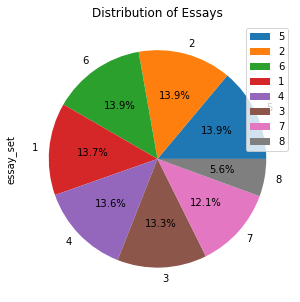

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df['essay_set'].value_counts().plot(kind='pie', figsize=(5,5), autopct ='%1.1f%%', title = 'Distribution of Essays')
plt.legend()

## Distribution of essay scores per set

<AxesSubplot:title={'center':'domain1_score'}, xlabel='essay_set'>

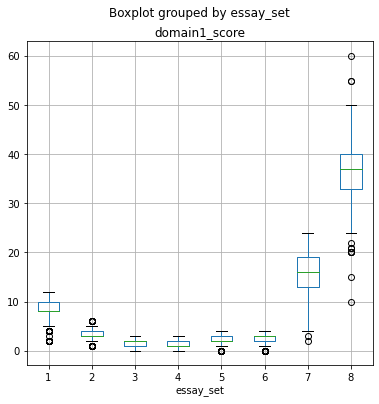

In [6]:
df.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (6, 6))

### Extraction of features from another file and saved in a pkl file

In [7]:
full_df= pd.read_pickle('full_df.pkl')
# essay_length  word_count  sentence_count  unique_words  lexical_richness  punctuation_count  spelling_errors
pos_df = pd.read_pickle('pos_df.pkl')

In [8]:
pos_df.columns

Index(['noun_%', 'pronoun_%', 'verb_%', 'adj_%', 'dt_%'], dtype='object')

In [9]:
eng_feat_df = pd.concat((full_df[['essay_length', 'word_count', 'sentence_count', 'unique_words', 'lexical_richness', 'punctuation_count', 'spelling_errors']], pos_df), axis = 1)


In [10]:
df = pd.concat((df, eng_feat_df), axis = 1)
df.shape[0]

12976

In [11]:
import nltk
import nltk.stem as ns
import string
import re
ps = ns.PorterStemmer()
lemma = ns.WordNetLemmatizer()

from nltk.tokenize import word_tokenize
def remove_punctuation(x):
    punctuation = string.punctuation
    no_punct = "".join([word for word in x if word not in punctuation])
    return no_punct

def remove_stopwords(x):
    stopwords = nltk.corpus.stopwords.words('english')
    no_sw = [word for word in x if word not in stopwords]
    return no_sw

#function built to use either stemming or lematization
def lemmatize(x):
    lemmatized = [lemma.lemmatize(word) for word in x]
    return lemmatized


#all of those functions inside one function to keep code clean
def clean_data(x):
    #tokens = re.sub("[^a-zA-Z]", " ", x.lower())
    essay_v = re.sub("[^a-zA-Z]", " ", x)
    tokens = essay_v.lower().split()
    no_sw = remove_stopwords(tokens)
    root = lemmatize(no_sw)
    return root

In [12]:
df['cleaned'] = df['essay'].apply(lambda x : clean_data(x))
df['essay_length'] = df['essay'].apply(lambda x: len(x))

In [13]:
def create_sets(df):
    sets = []
    max_scores = []
    min_scores = []
    for i in range(1, 9):
        s_df = df[df['essay_set'] == i] 
        max_score = s_df['domain1_score'].max()
        min_score = s_df['domain1_score'].min()
        sets.append(s_df)
        max_scores.append(max_score)
        min_scores.append(min_score)
    return sets, max_scores, min_scores
    

In [14]:
sets, max_scores, min_scores = create_sets(df)
for i, (max_s, min_s) in enumerate(zip(max_scores, min_scores)):
    print(f'set{i+1} min score: {min_s}  | max score: {max_s}')
    

set1 min score: 2  | max score: 12
set2 min score: 1  | max score: 6
set3 min score: 0  | max score: 3
set4 min score: 0  | max score: 3
set5 min score: 0  | max score: 4
set6 min score: 0  | max score: 4
set7 min score: 2  | max score: 24
set8 min score: 10  | max score: 60


## Correlations between features and score

<AxesSubplot:xlabel='lexical_richness', ylabel='domain1_score'>

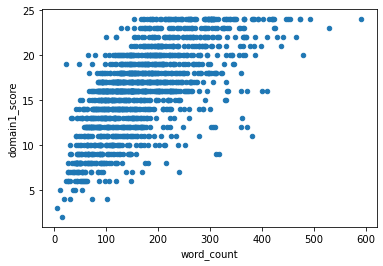

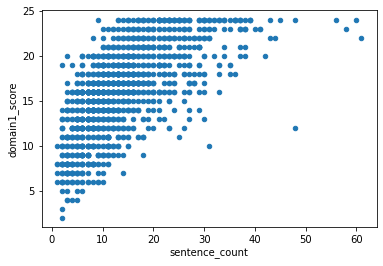

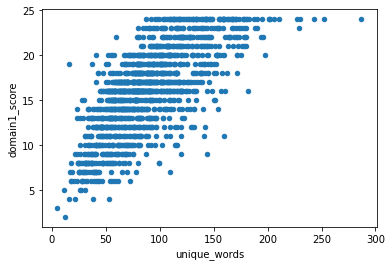

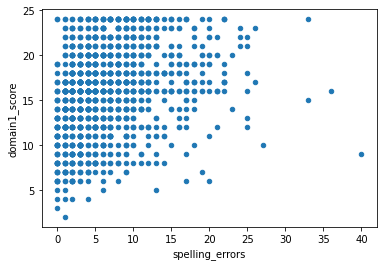

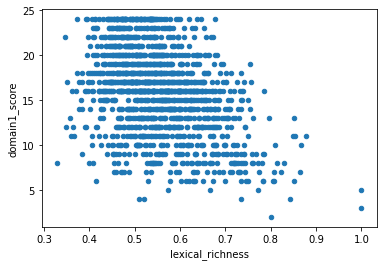

In [15]:
sets[6].plot.scatter(x =  'word_count', y ='domain1_score')
sets[6].plot.scatter(x =  'sentence_count', y ='domain1_score')
sets[6].plot.scatter(x =  'unique_words', y ='domain1_score')
sets[6].plot.scatter(x =  'spelling_errors', y ='domain1_score')
sets[6].plot.scatter(x =  'lexical_richness', y ='domain1_score')

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import cohen_kappa_score

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

with open('glove_embed.pickle', 'rb') as handle:
    glove = pickle.load(handle)

def create_embedding_matrix(word_index, embedding_dict, dim):
    '''
        Returns embedding matrix with shape 
        (vocab_length x embedding dimension)
    '''
    mean = np.zeros(dim)
    unk = []
    
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
        else:
            unk.append(i)
            
    mean /= len(word_index)-len(unk)
            
    for i in unk:
        embedding_matrix[i] = mean
        
    return embedding_matrix

In [18]:
from torch.utils.data import Dataset, DataLoader

def collate_fn(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, labels, lengths = zip(*data)
    #print(labels)
    max_len = max(lengths)
    n_ftrs = data[0][0].size(1)
    features = torch.zeros((len(data), max_len, n_ftrs))
    labels = torch.tensor(labels)
    lengths = torch.tensor(lengths)

    for i in range(len(data)):
        j, k = data[i][0].size(0), data[i][0].size(1)
        features[i] = torch.cat([data[i][0], torch.zeros((max_len - j, k))])

    return features.long(), labels.float()

class EssayDataset(Dataset):
    def __init__(self, dataset):
        self.x = dataset['vecs'].values
        self.y = torch.FloatTensor(dataset['domain1_score'].values)
        self.n_samples = dataset.shape[0]
        
    def __getitem__ (self, index):
        return self.x[index], self.y[index], len(self.x[index])
    
    def __len__(self):
        return self.n_samples
        

## Creating LSTM Network

In [19]:
import torch.nn.functional as F
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, out_neuron, pretrained_weights):
        super(LSTMNetwork, self).__init__()
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.num_directions = 1
        self.out_neuron = out_neuron
        self.dropout = nn.Dropout(p=0.53)
        
            
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_weights))
            
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_size, self.n_layers, batch_first = True)
        
        self.linear = nn.Linear(self.hidden_size*self.num_directions, 1)
        
    def forward(self, x):

        embedding_t = self.embedding(x) 
        # input is a "list" sentences where each sentence is a vector of "encoded words" 
        # out.shape = [sentence_length,batch_size,embedding_dimension], in.shape = [sentence_length,batch_size]

        drop_emb = self.dropout(embedding_t)

        out, (hidden_state,_) = self.lstm(drop_emb)
        #out = torch.transpose(out, 0, 1)

        hidden_squeezed = hidden_state.squeeze(0) 
        # shape of hidden_state = (num_layers * num_directions, batch, hidden_size) = (1*1,b,h) so extra 1 layer
        
        assert torch.equal(out[:,-1,:],hidden_squeezed)
        # out_rnn is concatenation of hidden states so squeezed hidden and last value of out_rnn should be equal
 
        return F.relu(self.linear(hidden_squeezed)) 

In [20]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pd.options.mode.chained_assignment = None  # default='warn'



def embed_glove(x, t):
    # adds words to word lookup dictionary
    t.fit_on_texts(x)
    # gives a list of values that represent indices to look up in the embedding matrix
    tokens = t.texts_to_sequences(x)
    
    text_tokens = torch.LongTensor(tokens)
    
    return text_tokens



def check_accuracy(preds, target):
    correct_preds = (preds == target).float()
        # get a floating tensors of predicted classes  which match original true class 
        
    accuracy = correct_preds.sum()/len(correct_preds)# it'll be a tensor of shape [1,]
    return accuracy
    
    

def train_model(train_dataloader, model, criterion, optimizer):
    correct = 0
    e_loss = 0

    model.train()
    for inputs, labels in tqdm(train_dataloader):
        #print(inputs)
        optimizer.zero_grad()
        inputs = inputs.squeeze(2)
        #print(inputs.shape)
        #print(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        
        pred = model(inputs).squeeze(1)
        loss = criterion(pred, labels)
        
        pred_classes = torch.round(pred)
        
        loss.backward()
        optimizer.step()
        
        
        correct += check_accuracy(pred_classes, labels).item()
        e_loss += loss.item()       
        
        
        
    return correct/len(train_dataloader), e_loss/len(train_dataloader)

def evaluate(test_dataloader, model, criterion):
    correct = 0
    e_loss = 0
    kaps = []
    model.eval()
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.squeeze(2)
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            pred = model(inputs).squeeze(1)
            loss = criterion(pred, labels)
        
            pred_classes = torch.round(pred)
            
            correct += check_accuracy(pred_classes, labels).item()
            e_loss += loss.item()
            
            result = cohen_kappa_score(pred_classes.cpu().detach().numpy(), labels.cpu().detach().numpy(), weights='quadratic')
            kaps.append(result)
            

            
    return correct/len(test_dataloader), e_loss/len(test_dataloader), np.mean(np.asarray(kaps))
        
        


## GloVe + LSTM Trained per set

In [21]:

t = Tokenizer()

train_dataloaders = []
test_dataloaders = []

for df_set in sets:
    s_df = df_set[['domain1_score', 'cleaned']]
    train, test = train_test_split(s_df, test_size = 0.2, random_state = 42)

    train['vecs'] = train['cleaned'].apply(lambda x : embed_glove(x, t))
    test['vecs'] = test['cleaned'].apply(lambda x : embed_glove(x, t))
    
    train_essayset = EssayDataset(train)
    train_dataloader = DataLoader(dataset = train_essayset, batch_size = 50, shuffle = False, collate_fn = collate_fn)
    
    test_essayset = EssayDataset(test)
    test_dataloader = DataLoader(dataset = test_essayset, batch_size = 50, shuffle = False, collate_fn = collate_fn)
    
    train_dataloaders.append(train_dataloader)
    test_dataloaders.append(test_dataloader)
    

embedding_matrix = create_embedding_matrix(t.word_index, glove, dim = 200)

INPUT_SIZE = embedding_matrix.shape[0]
text_embedding_dim = 200
HIDDEN_SIZE = 512
OUTPUT = 1
lr = 0.003


lstm_model = LSTMNetwork(INPUT_SIZE, text_embedding_dim, HIDDEN_SIZE, OUTPUT, embedding_matrix)
lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(),lr=lr)  

EPOCHS = 50

epoch_losses = []
epoch_accs = []
kappa_per_set = []

for idx, (tr_dataloader, tst_dataloader) in enumerate(zip(train_dataloaders,test_dataloaders)):  
    train_accs = []
    train_losses = []
    kappa_epoch = []
    print(f'=================== Set{idx+1} ===================')
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_model(tr_dataloader, lstm_model, criterion, optimizer)
        test_acc, test_loss, kappa = evaluate(tst_dataloader, lstm_model, criterion)
        
        print(f'Set {idx+1} | Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc} | Train Loss: {train_loss}')
        print(f'Test Acc: {test_acc} | Test Loss: {test_loss} | Kappa for set{idx+1} : {kappa}')
        
        
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        kappa_epoch.append(kappa)
        
        
    
    kappa_per_set.append(np.mean(np.asarray(kappa_epoch)))
    
    epoch_accs.append(train_acc)    
    epoch_losses.append(train_losses)

=================== Set1 ===================


100%|██████████| 8/8 [00:00<00:00, 35.57it/s]


Set 1 | Epoch 1/50 | Train Acc: 0.14233421315920763 | Train Loss: 36.13862442559209
Test Acc: 0.17285714065656066 | Test Loss: 2.479938045144081 | Kappa for set1 : 0.0


100%|██████████| 8/8 [00:00<00:00, 35.71it/s]


Set 1 | Epoch 2/50 | Train Acc: 0.2788859351441778 | Train Loss: 2.4438715104399056
Test Acc: 0.17285714065656066 | Test Loss: 2.320265606045723 | Kappa for set1 : 0.0


100%|██████████| 8/8 [00:00<00:00, 34.95it/s]


Set 1 | Epoch 3/50 | Train Acc: 0.27336869440202055 | Train Loss: 2.499198527171694
Test Acc: 0.17285714065656066 | Test Loss: 2.3484835624694824 | Kappa for set1 : 0.0


100%|██████████| 8/8 [00:00<00:00, 35.65it/s]


Set 1 | Epoch 4/50 | Train Acc: 0.28923076262761804 | Train Loss: 2.4889054915000655
Test Acc: 0.17285714065656066 | Test Loss: 2.2923834770917892 | Kappa for set1 : 0.0


100%|██████████| 8/8 [00:00<00:00, 35.65it/s]


Set 1 | Epoch 5/50 | Train Acc: 0.2906100731985322 | Train Loss: 2.478744856242476
Test Acc: 0.17285714065656066 | Test Loss: 2.259138762950897 | Kappa for set1 : 0.0


100%|██████████| 8/8 [00:00<00:00, 35.65it/s]


Set 1 | Epoch 6/50 | Train Acc: 0.2926790380272372 | Train Loss: 2.4111775817542243
Test Acc: 0.17785714147612453 | Test Loss: 2.222665175795555 | Kappa for set1 : 0.019287025117078985


100%|██████████| 8/8 [00:00<00:00, 35.18it/s]


Set 1 | Epoch 7/50 | Train Acc: 0.2919893829986967 | Train Loss: 2.467128560460847
Test Acc: 0.18035714095458388 | Test Loss: 2.2153313905000687 | Kappa for set1 : 0.022031184981981866


100%|██████████| 8/8 [00:00<00:00, 35.34it/s]


Set 1 | Epoch 8/50 | Train Acc: 0.28509283168562527 | Train Loss: 2.4678419417348403
Test Acc: 0.18035714095458388 | Test Loss: 2.1628520488739014 | Kappa for set1 : 0.08355042114002495


100%|██████████| 8/8 [00:00<00:00, 35.41it/s]


Set 1 | Epoch 9/50 | Train Acc: 0.29129972745632304 | Train Loss: 2.379933081824204
Test Acc: 0.18285713670775294 | Test Loss: 2.180408462882042 | Kappa for set1 : 0.04279223813967882


100%|██████████| 8/8 [00:00<00:00, 35.26it/s]


Set 1 | Epoch 10/50 | Train Acc: 0.29405834885506793 | Train Loss: 2.423764635776651
Test Acc: 0.17785713775083423 | Test Loss: 2.0925519689917564 | Kappa for set1 : 0.10397651027384434


100%|██████████| 8/8 [00:00<00:00, 35.34it/s]


Set 1 | Epoch 11/50 | Train Acc: 0.2933686938265274 | Train Loss: 2.4223637334231674
Test Acc: 0.18035713722929358 | Test Loss: 2.1835200786590576 | Kappa for set1 : 0.10138697210811266


100%|██████████| 8/8 [00:00<00:00, 35.18it/s]


Set 1 | Epoch 12/50 | Train Acc: 0.29336869356961087 | Train Loss: 2.396192036826035
Test Acc: 0.18035713722929358 | Test Loss: 2.0855112560093403 | Kappa for set1 : 0.10917566894007123


100%|██████████| 8/8 [00:00<00:00, 35.57it/s]


Set 1 | Epoch 13/50 | Train Acc: 0.2961273141976061 | Train Loss: 2.4006881426120628
Test Acc: 0.17785713775083423 | Test Loss: 2.1112058088183403 | Kappa for set1 : 0.10397651027384434


100%|██████████| 8/8 [00:00<00:00, 34.43it/s]


Set 1 | Epoch 14/50 | Train Acc: 0.2988859348256013 | Train Loss: 2.38648390358892
Test Acc: 0.18285713717341423 | Test Loss: 2.1057736426591873 | Kappa for set1 : 0.11160261540016143


100%|██████████| 8/8 [00:00<00:00, 35.49it/s]


Set 1 | Epoch 15/50 | Train Acc: 0.2975066252823534 | Train Loss: 2.326576664529998
Test Acc: 0.18285713717341423 | Test Loss: 2.098912164568901 | Kappa for set1 : 0.11160261540016143


100%|██████████| 8/8 [00:00<00:00, 34.72it/s]


Set 1 | Epoch 16/50 | Train Acc: 0.30233421048213693 | Train Loss: 2.384889499894504
Test Acc: 0.18285713717341423 | Test Loss: 2.1127119846642017 | Kappa for set1 : 0.11160261540016143


100%|██████████| 8/8 [00:00<00:00, 35.34it/s]


Set 1 | Epoch 17/50 | Train Acc: 0.3016445551966799 | Train Loss: 2.3766682189086388
Test Acc: 0.18285713717341423 | Test Loss: 2.0903741158545017 | Kappa for set1 : 0.11160261540016143


100%|██████████| 8/8 [00:00<00:00, 34.72it/s]


Set 1 | Epoch 18/50 | Train Acc: 0.3023342099683038 | Train Loss: 2.318002803572293
Test Acc: 0.18285713717341423 | Test Loss: 2.098463173955679 | Kappa for set1 : 0.11160261540016143


100%|██████████| 8/8 [00:00<00:00, 34.97it/s]


Set 1 | Epoch 19/50 | Train Acc: 0.30042439673481314 | Train Loss: 2.684650647229162
Test Acc: 0.42178570479154587 | Test Loss: 2.2591711431741714 | Kappa for set1 : 0.15835123788353322


100%|██████████| 8/8 [00:00<00:00, 34.35it/s]


Set 1 | Epoch 20/50 | Train Acc: 0.29336869279886113 | Train Loss: 2.5583076600370735
Test Acc: 0.17285714065656066 | Test Loss: 2.3552264124155045 | Kappa for set1 : 0.0


100%|██████████| 8/8 [00:00<00:00, 34.87it/s]


Set 1 | Epoch 21/50 | Train Acc: 0.27405834943056107 | Train Loss: 2.5237721369184296
Test Acc: 0.17535714199766517 | Test Loss: 2.3719194680452347 | Kappa for set1 : 0.004538323621694318


100%|██████████| 8/8 [00:00<00:00, 34.76it/s]


Set 1 | Epoch 22/50 | Train Acc: 0.28647214225653944 | Train Loss: 2.393594429410737
Test Acc: 0.18035714095458388 | Test Loss: 2.277076095342636 | Kappa for set1 : 0.08355042114002495


100%|██████████| 8/8 [00:00<00:00, 34.57it/s]


Set 1 | Epoch 23/50 | Train Acc: 0.2871617967712468 | Train Loss: 2.362224455537467
Test Acc: 0.18035714095458388 | Test Loss: 2.2340574264526367 | Kappa for set1 : 0.08355042114002495


100%|██████████| 8/8 [00:00<00:00, 34.88it/s]


Set 1 | Epoch 24/50 | Train Acc: 0.2850928311717921 | Train Loss: 2.4460021380720467
Test Acc: 0.18035713722929358 | Test Loss: 2.1903110444545746 | Kappa for set1 : 0.10138697210811266


100%|██████████| 8/8 [00:00<00:00, 34.35it/s]


Set 1 | Epoch 25/50 | Train Acc: 0.29819627954014416 | Train Loss: 2.340486658030543
Test Acc: 0.17785713775083423 | Test Loss: 2.1763611435890198 | Kappa for set1 : 0.10397651027384434


100%|██████████| 8/8 [00:00<00:00, 35.49it/s]


Set 1 | Epoch 26/50 | Train Acc: 0.2912997277132396 | Train Loss: 2.425680197518447
Test Acc: 0.18035713722929358 | Test Loss: 2.160353444516659 | Kappa for set1 : 0.10917566894007123


100%|██████████| 8/8 [00:00<00:00, 34.88it/s]


Set 1 | Epoch 27/50 | Train Acc: 0.28992041765615856 | Train Loss: 2.329465085062487
Test Acc: 0.17785713775083423 | Test Loss: 2.182121768593788 | Kappa for set1 : 0.10397651027384434


100%|██████████| 8/8 [00:00<00:00, 34.28it/s]


Set 1 | Epoch 28/50 | Train Acc: 0.30095490016813936 | Train Loss: 2.3711881432039985
Test Acc: 0.18035713722929358 | Test Loss: 2.159723684191704 | Kappa for set1 : 0.10917566894007123


100%|██████████| 8/8 [00:00<00:00, 34.95it/s]


Set 1 | Epoch 29/50 | Train Acc: 0.2906100726846991 | Train Loss: 2.3180388705483796
Test Acc: 0.18035713722929358 | Test Loss: 2.1576062217354774 | Kappa for set1 : 0.11269482939293358


100%|██████████| 8/8 [00:00<00:00, 35.04it/s]


Set 1 | Epoch 30/50 | Train Acc: 0.3016445549397633 | Train Loss: 2.401028333039119
Test Acc: 0.18285713717341423 | Test Loss: 2.1303967125713825 | Kappa for set1 : 0.11512177585302379


100%|██████████| 8/8 [00:00<00:00, 34.88it/s]


Set 1 | Epoch 31/50 | Train Acc: 0.30095489991122276 | Train Loss: 2.3615775848257132
Test Acc: 0.18035713722929358 | Test Loss: 2.1302261985838413 | Kappa for set1 : 0.11269482939293358


100%|██████████| 8/8 [00:00<00:00, 30.85it/s]


Set 1 | Epoch 32/50 | Train Acc: 0.29957559011105833 | Train Loss: 2.3712616665609954
Test Acc: 0.18285713717341423 | Test Loss: 2.136023908853531 | Kappa for set1 : 0.11512177585302379


100%|██████████| 8/8 [00:00<00:00, 35.03it/s]


Set 1 | Epoch 33/50 | Train Acc: 0.31129972739466305 | Train Loss: 2.4813905789934356
Test Acc: 0.18035713769495487 | Test Loss: 2.14198312535882 | Kappa for set1 : 0.12039087088275258


100%|██████████| 8/8 [00:00<00:00, 35.65it/s]


Set 1 | Epoch 34/50 | Train Acc: 0.3023342102252204 | Train Loss: 2.374508105475327
Test Acc: 0.18285713717341423 | Test Loss: 2.1340983621776104 | Kappa for set1 : 0.11512177585302379


100%|██████████| 8/8 [00:00<00:00, 35.34it/s]


Set 1 | Epoch 35/50 | Train Acc: 0.3023342102252204 | Train Loss: 2.368275358759124
Test Acc: 0.18285713717341423 | Test Loss: 2.136771574616432 | Kappa for set1 : 0.11512177585302379


100%|██████████| 8/8 [00:00<00:00, 35.18it/s]


Set 1 | Epoch 36/50 | Train Acc: 0.30503978092094947 | Train Loss: 2.313090645033738
Test Acc: 0.18035713769495487 | Test Loss: 2.135303869843483 | Kappa for set1 : 0.12039087088275258


100%|██████████| 8/8 [00:00<00:00, 34.72it/s]


Set 1 | Epoch 37/50 | Train Acc: 0.3029708155784114 | Train Loss: 2.3098886958483993
Test Acc: 0.18035713769495487 | Test Loss: 2.128846462816 | Kappa for set1 : 0.12280621215588766


100%|██████████| 8/8 [00:00<00:00, 35.03it/s]


Set 1 | Epoch 38/50 | Train Acc: 0.30366046906545247 | Train Loss: 2.3657488864043663
Test Acc: 0.18035713769495487 | Test Loss: 2.124631240963936 | Kappa for set1 : 0.12039087088275258


100%|██████████| 8/8 [00:00<00:00, 34.49it/s]


Set 1 | Epoch 39/50 | Train Acc: 0.30366047009311875 | Train Loss: 2.4327508745522333
Test Acc: 0.18035713769495487 | Test Loss: 2.130790803581476 | Kappa for set1 : 0.12039087088275258


100%|██████████| 8/8 [00:00<00:00, 34.72it/s]


Set 1 | Epoch 40/50 | Train Acc: 0.3015915047505806 | Train Loss: 2.4082590629314553
Test Acc: 0.18035713722929358 | Test Loss: 2.1175831593573093 | Kappa for set1 : 0.11391432488493052


100%|██████████| 8/8 [00:00<00:00, 35.34it/s]


Set 1 | Epoch 41/50 | Train Acc: 0.2864721417427063 | Train Loss: 2.7703023203488053
Test Acc: 0.17285714065656066 | Test Loss: 2.2593999803066254 | Kappa for set1 : 0.0


100%|██████████| 8/8 [00:00<00:00, 34.73it/s]


Set 1 | Epoch 42/50 | Train Acc: 0.28647214225653944 | Train Loss: 2.36996158238115
Test Acc: 0.17785714147612453 | Test Loss: 2.255116805434227 | Kappa for set1 : 0.014038774533940021


100%|██████████| 8/8 [00:00<00:00, 34.90it/s]


Set 1 | Epoch 43/50 | Train Acc: 0.27888593540109435 | Train Loss: 2.3767661760593284
Test Acc: 0.18035714095458388 | Test Loss: 2.2883253544569016 | Kappa for set1 : 0.02762936850844601


100%|██████████| 8/8 [00:00<00:00, 35.06it/s]


Set 1 | Epoch 44/50 | Train Acc: 0.2871617967712468 | Train Loss: 2.3601153184627663
Test Acc: 0.18035714095458388 | Test Loss: 2.20226289331913 | Kappa for set1 : 0.08355042114002495


100%|██████████| 8/8 [00:00<00:00, 34.28it/s]


Set 1 | Epoch 45/50 | Train Acc: 0.2844031761432516 | Train Loss: 2.4657504928523095
Test Acc: 0.17785713775083423 | Test Loss: 2.181084342300892 | Kappa for set1 : 0.10397651027384434


100%|██████████| 8/8 [00:00<00:00, 35.18it/s]


Set 1 | Epoch 46/50 | Train Acc: 0.2775066256009299 | Train Loss: 2.3330772580771613
Test Acc: 0.18035713722929358 | Test Loss: 2.228722482919693 | Kappa for set1 : 0.10917566894007123


100%|██████████| 8/8 [00:00<00:00, 35.31it/s]


Set 1 | Epoch 47/50 | Train Acc: 0.30026524513959885 | Train Loss: 2.3260232580119165
Test Acc: 0.18035713722929358 | Test Loss: 2.13503684848547 | Kappa for set1 : 0.10917566894007123


100%|██████████| 8/8 [00:00<00:00, 34.88it/s]


Set 1 | Epoch 48/50 | Train Acc: 0.3002652446257657 | Train Loss: 2.3184265720433204
Test Acc: 0.18035713722929358 | Test Loss: 2.1456364318728447 | Kappa for set1 : 0.10917566894007123


100%|██████████| 8/8 [00:00<00:00, 32.61it/s]


Set 1 | Epoch 49/50 | Train Acc: 0.3002652446257657 | Train Loss: 2.3748358693616143
Test Acc: 0.18035713722929358 | Test Loss: 2.142097406089306 | Kappa for set1 : 0.10917566894007123


100%|██████████| 8/8 [00:00<00:00, 35.40it/s]


Set 1 | Epoch 50/50 | Train Acc: 0.30095490119580565 | Train Loss: 2.3724392858044854
Test Acc: 0.18035713722929358 | Test Loss: 2.1371206119656563 | Kappa for set1 : 0.10917566894007123
=================== Set2 ===================


100%|██████████| 8/8 [00:00<00:00, 30.16it/s]


Set 2 | Epoch 1/50 | Train Acc: 0.16534482315182686 | Train Loss: 4.818989304632976
Test Acc: 0.44749999046325684 | Test Loss: 0.6091130562126637 | Kappa for set2 : 0.12743244635624557


100%|██████████| 8/8 [00:00<00:00, 29.22it/s]


Set 2 | Epoch 2/50 | Train Acc: 0.4191379192574271 | Train Loss: 0.7215129866682249
Test Acc: 0.44749999046325684 | Test Loss: 0.5415775626897812 | Kappa for set2 : 0.12743244635624557


100%|██████████| 8/8 [00:00<00:00, 29.37it/s]


Set 2 | Epoch 3/50 | Train Acc: 0.42396550548487694 | Train Loss: 0.634114433979166
Test Acc: 0.44749999046325684 | Test Loss: 0.5364830605685711 | Kappa for set2 : 0.11787065644609133


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Set 2 | Epoch 4/50 | Train Acc: 0.4163792976017656 | Train Loss: 0.6283564105116087
Test Acc: 0.4599999934434891 | Test Loss: 0.5380178429186344 | Kappa for set2 : 0.10540626898170387


100%|██████████| 8/8 [00:00<00:00, 29.13it/s]


Set 2 | Epoch 5/50 | Train Acc: 0.4253448145142917 | Train Loss: 0.6162687170094457
Test Acc: 0.4624999910593033 | Test Loss: 0.5356946587562561 | Kappa for set2 : 0.08826217190463798


100%|██████████| 8/8 [00:00<00:00, 29.59it/s]


Set 2 | Epoch 6/50 | Train Acc: 0.41844826474271973 | Train Loss: 0.6326198649817499
Test Acc: 0.4624999947845936 | Test Loss: 0.5367631278932095 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.43it/s]


Set 2 | Epoch 7/50 | Train Acc: 0.4281034366837863 | Train Loss: 0.6139183979609917
Test Acc: 0.4624999947845936 | Test Loss: 0.5355489104986191 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.47it/s]


Set 2 | Epoch 8/50 | Train Acc: 0.41568964411472453 | Train Loss: 0.6381225483170871
Test Acc: 0.4624999947845936 | Test Loss: 0.5354565717279911 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.61it/s]


Set 2 | Epoch 9/50 | Train Acc: 0.41775860868651293 | Train Loss: 0.6039609785737663
Test Acc: 0.4624999947845936 | Test Loss: 0.5351927690207958 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.71it/s]


Set 2 | Epoch 10/50 | Train Acc: 0.4143103330299772 | Train Loss: 0.6203553142218754
Test Acc: 0.4624999947845936 | Test Loss: 0.5346747376024723 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.61it/s]


Set 2 | Epoch 11/50 | Train Acc: 0.4129310219452299 | Train Loss: 0.6163106098257262
Test Acc: 0.4624999947845936 | Test Loss: 0.5347683317959309 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Set 2 | Epoch 12/50 | Train Acc: 0.4129310219452299 | Train Loss: 0.6161388693184688
Test Acc: 0.4624999947845936 | Test Loss: 0.5345814861357212 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.88it/s]


Set 2 | Epoch 13/50 | Train Acc: 0.4129310219452299 | Train Loss: 0.6153820413967659
Test Acc: 0.4624999947845936 | Test Loss: 0.5343113839626312 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.48it/s]


Set 2 | Epoch 14/50 | Train Acc: 0.4129310219452299 | Train Loss: 0.6272442978003929
Test Acc: 0.4624999947845936 | Test Loss: 0.5345710515975952 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.54it/s]


Set 2 | Epoch 15/50 | Train Acc: 0.41224136743052253 | Train Loss: 0.6223446254072518
Test Acc: 0.4624999947845936 | Test Loss: 0.5343046858906746 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.97it/s]


Set 2 | Epoch 16/50 | Train Acc: 0.41775860663118036 | Train Loss: 0.6620335054808649
Test Acc: 0.4624999947845936 | Test Loss: 0.5345177464187145 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.59it/s]


Set 2 | Epoch 17/50 | Train Acc: 0.4136206764599373 | Train Loss: 0.6076107888386167
Test Acc: 0.4624999947845936 | Test Loss: 0.5343739725649357 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 30.01it/s]


Set 2 | Epoch 18/50 | Train Acc: 0.4184482611458877 | Train Loss: 0.6369799581067316
Test Acc: 0.4624999947845936 | Test Loss: 0.5341107621788979 | Kappa for set2 : 0.07772200666300597


100%|██████████| 8/8 [00:00<00:00, 29.89it/s]


Set 2 | Epoch 19/50 | Train Acc: 0.4191379177159277 | Train Loss: 0.6137657144974018
Test Acc: 0.4649999924004078 | Test Loss: 0.5341002531349659 | Kappa for set2 : 0.08418791166480519


100%|██████████| 8/8 [00:00<00:00, 29.92it/s]


Set 2 | Epoch 20/50 | Train Acc: 0.4163792976017656 | Train Loss: 0.6223221195155176
Test Acc: 0.4649999924004078 | Test Loss: 0.5341982766985893 | Kappa for set2 : 0.08418791166480519


100%|██████████| 8/8 [00:00<00:00, 29.93it/s]


Set 2 | Epoch 21/50 | Train Acc: 0.4184482632012203 | Train Loss: 0.625399212385046
Test Acc: 0.4649999924004078 | Test Loss: 0.5340364500880241 | Kappa for set2 : 0.08418791166480519


100%|██████████| 8/8 [00:00<00:00, 29.11it/s]


Set 2 | Epoch 22/50 | Train Acc: 0.4191379177159277 | Train Loss: 0.6358128816917025
Test Acc: 0.467499990016222 | Test Loss: 0.5338038094341755 | Kappa for set2 : 0.09061044510195418


100%|██████████| 8/8 [00:00<00:00, 29.16it/s]


Set 2 | Epoch 23/50 | Train Acc: 0.41706895417180556 | Train Loss: 0.620547339834016
Test Acc: 0.4649999924004078 | Test Loss: 0.5346356816589832 | Kappa for set2 : 0.08418791166480519


100%|██████████| 8/8 [00:00<00:00, 29.06it/s]


Set 2 | Epoch 24/50 | Train Acc: 0.41913791874359396 | Train Loss: 0.6208781846638384
Test Acc: 0.45499998703598976 | Test Loss: 0.5358442217111588 | Kappa for set2 : 0.10307483256634165


100%|██████████| 8/8 [00:00<00:00, 29.38it/s]


Set 2 | Epoch 25/50 | Train Acc: 0.41775860868651293 | Train Loss: 0.628677512037343
Test Acc: 0.45499998703598976 | Test Loss: 0.5361740738153458 | Kappa for set2 : 0.10307483256634165


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Set 2 | Epoch 26/50 | Train Acc: 0.41913791977126025 | Train Loss: 0.6613913096230606
Test Acc: 0.467499990016222 | Test Loss: 0.5358971245586872 | Kappa for set2 : 0.09061044510195418


100%|██████████| 8/8 [00:00<00:00, 29.49it/s]


Set 2 | Epoch 27/50 | Train Acc: 0.41775860765884665 | Train Loss: 0.6245492820082039
Test Acc: 0.467499990016222 | Test Loss: 0.5363455675542355 | Kappa for set2 : 0.09061044510195418


100%|██████████| 8/8 [00:00<00:00, 29.17it/s]


Set 2 | Epoch 28/50 | Train Acc: 0.41913791874359396 | Train Loss: 0.6423107272592085
Test Acc: 0.41999998688697815 | Test Loss: 0.5390426032245159 | Kappa for set2 : 0.0515708543362758


100%|██████████| 8/8 [00:00<00:00, 29.93it/s]


Set 2 | Epoch 29/50 | Train Acc: 0.4232758499425033 | Train Loss: 0.6469157255929092
Test Acc: 0.41999998688697815 | Test Loss: 0.5388274155557156 | Kappa for set2 : 0.0515708543362758


100%|██████████| 8/8 [00:00<00:00, 29.82it/s]


Set 2 | Epoch 30/50 | Train Acc: 0.4232758499425033 | Train Loss: 0.6421320428108347
Test Acc: 0.41999998688697815 | Test Loss: 0.5404873788356781 | Kappa for set2 : 0.0515708543362758


100%|██████████| 8/8 [00:00<00:00, 29.43it/s]


Set 2 | Epoch 31/50 | Train Acc: 0.4370689535963124 | Train Loss: 0.6319713900829184
Test Acc: 0.4349999874830246 | Test Loss: 0.5404009707272053 | Kappa for set2 : 0.02008958190251635


100%|██████████| 8/8 [00:00<00:00, 29.55it/s]


Set 2 | Epoch 32/50 | Train Acc: 0.43499998696919145 | Train Loss: 0.6403722485591625
Test Acc: 0.41999998688697815 | Test Loss: 0.5418297499418259 | Kappa for set2 : 0.0388000513105127


100%|██████████| 8/8 [00:00<00:00, 30.16it/s]


Set 2 | Epoch 33/50 | Train Acc: 0.4356896435392314 | Train Loss: 0.6871773939708183
Test Acc: 0.41999998688697815 | Test Loss: 0.5431158319115639 | Kappa for set2 : 0.05191412291750687


100%|██████████| 8/8 [00:00<00:00, 29.78it/s]


Set 2 | Epoch 34/50 | Train Acc: 0.43982757473814077 | Train Loss: 0.632642900121623
Test Acc: 0.41999998688697815 | Test Loss: 0.5445343367755413 | Kappa for set2 : 0.05191412291750687


100%|██████████| 8/8 [00:00<00:00, 29.48it/s]


Set 2 | Epoch 35/50 | Train Acc: 0.4370689535963124 | Train Loss: 0.6558387495320419
Test Acc: 0.41749998554587364 | Test Loss: 0.5468687005341053 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Set 2 | Epoch 36/50 | Train Acc: 0.43862067728207027 | Train Loss: 0.6358383863136686
Test Acc: 0.41749998554587364 | Test Loss: 0.5488708280026913 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.38it/s]


Set 2 | Epoch 37/50 | Train Acc: 0.43637929908160505 | Train Loss: 0.6574868436517387
Test Acc: 0.41749998554587364 | Test Loss: 0.5473656989634037 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.76it/s]


Set 2 | Epoch 38/50 | Train Acc: 0.4391379202234334 | Train Loss: 0.6448080354723437
Test Acc: 0.4299999848008156 | Test Loss: 0.5455748960375786 | Kappa for set2 : 0.013789427866088486


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Set 2 | Epoch 39/50 | Train Acc: 0.44068964390919124 | Train Loss: 0.6401198475525297
Test Acc: 0.41749998554587364 | Test Loss: 0.548018679022789 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Set 2 | Epoch 40/50 | Train Acc: 0.43862067728207027 | Train Loss: 0.6655136429030319
Test Acc: 0.4299999848008156 | Test Loss: 0.5505770705640316 | Kappa for set2 : 0.013789427866088486


100%|██████████| 8/8 [00:00<00:00, 29.74it/s]


Set 2 | Epoch 41/50 | Train Acc: 0.44068964288152496 | Train Loss: 0.6216632723808289
Test Acc: 0.41749998554587364 | Test Loss: 0.5544737614691257 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.59it/s]


Set 2 | Epoch 42/50 | Train Acc: 0.44068964288152496 | Train Loss: 0.6525949445264093
Test Acc: 0.41749998554587364 | Test Loss: 0.555225558578968 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.32it/s]


Set 2 | Epoch 43/50 | Train Acc: 0.4399999883668176 | Train Loss: 0.6313922374412931
Test Acc: 0.41749998554587364 | Test Loss: 0.5552410297095776 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.54it/s]


Set 2 | Epoch 44/50 | Train Acc: 0.4393103328244439 | Train Loss: 0.6386105151012026
Test Acc: 0.41749998554587364 | Test Loss: 0.5587846152484417 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.49it/s]


Set 2 | Epoch 45/50 | Train Acc: 0.4393103338521102 | Train Loss: 0.6287752338524523
Test Acc: 0.41749998554587364 | Test Loss: 0.5581268668174744 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.54it/s]


Set 2 | Epoch 46/50 | Train Acc: 0.4399999883668176 | Train Loss: 0.6619165262271618
Test Acc: 0.4299999848008156 | Test Loss: 0.5552758984267712 | Kappa for set2 : 0.026903499473082654


100%|██████████| 8/8 [00:00<00:00, 29.98it/s]


Set 2 | Epoch 47/50 | Train Acc: 0.44068964390919124 | Train Loss: 0.6253423896329157
Test Acc: 0.41749998554587364 | Test Loss: 0.5582441575825214 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.71it/s]


Set 2 | Epoch 48/50 | Train Acc: 0.43862067830973656 | Train Loss: 0.6627366645582791
Test Acc: 0.41749998554587364 | Test Loss: 0.5559756122529507 | Kappa for set2 : 0.05493044655128969


100%|██████████| 8/8 [00:00<00:00, 29.60it/s]


Set 2 | Epoch 49/50 | Train Acc: 0.4393103338521102 | Train Loss: 0.6494238869897251
Test Acc: 0.4274999834597111 | Test Loss: 0.5554772205650806 | Kappa for set2 : 0.029919823106865473


100%|██████████| 8/8 [00:00<00:00, 29.56it/s]


Set 2 | Epoch 50/50 | Train Acc: 0.44206895396627227 | Train Loss: 0.6360560984447085
Test Acc: 0.41749998554587364 | Test Loss: 0.5615738220512867 | Kappa for set2 : 0.05493044655128969
=================== Set3 ===================


100%|██████████| 7/7 [00:00<00:00, 75.64it/s]


Set 3 | Epoch 1/50 | Train Acc: 0.3233333257958293 | Train Loss: 1.2734063885041647
Test Acc: 0.4340372511318752 | Test Loss: 0.5828315317630768 | Kappa for set3 : 0.06085463551859734


100%|██████████| 7/7 [00:00<00:00, 72.38it/s]


Set 3 | Epoch 2/50 | Train Acc: 0.38119046709367205 | Train Loss: 0.7505939496415002
Test Acc: 0.42832296660968233 | Test Loss: 0.6636275138173785 | Kappa for set3 : 0.04488093399502562


100%|██████████| 7/7 [00:00<00:00, 73.11it/s]


Set 3 | Epoch 3/50 | Train Acc: 0.39119046713624683 | Train Loss: 0.6879277314458575
Test Acc: 0.4340372511318752 | Test Loss: 0.6283012969153268 | Kappa for set3 : 0.06085463551859734


100%|██████████| 7/7 [00:00<00:00, 74.95it/s]


Set 3 | Epoch 4/50 | Train Acc: 0.3933333232998848 | Train Loss: 0.6730618668454034
Test Acc: 0.43689439977918354 | Test Loss: 0.6191895774432591 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 73.45it/s]


Set 3 | Epoch 5/50 | Train Acc: 0.3947618954948017 | Train Loss: 0.6722246153014046
Test Acc: 0.43689439977918354 | Test Loss: 0.6150964839117867 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 72.71it/s]


Set 3 | Epoch 6/50 | Train Acc: 0.3940476104617119 | Train Loss: 0.6828243817601886
Test Acc: 0.43689439977918354 | Test Loss: 0.6152573313031878 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 73.09it/s]


Set 3 | Epoch 7/50 | Train Acc: 0.3954761815922601 | Train Loss: 0.6719972171953746
Test Acc: 0.43689439977918354 | Test Loss: 0.6139140214238848 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.83it/s]


Set 3 | Epoch 8/50 | Train Acc: 0.3947618954948017 | Train Loss: 0.6736647422824588
Test Acc: 0.43689439977918354 | Test Loss: 0.6190704873629979 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 77.13it/s]


Set 3 | Epoch 9/50 | Train Acc: 0.3947618954948017 | Train Loss: 0.6773768599544253
Test Acc: 0.43689439977918354 | Test Loss: 0.6127453872135707 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 76.64it/s]


Set 3 | Epoch 10/50 | Train Acc: 0.3952380876455988 | Train Loss: 0.6748608446546963
Test Acc: 0.43689439977918354 | Test Loss: 0.6097446382045746 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 72.71it/s]


Set 3 | Epoch 11/50 | Train Acc: 0.3947618954948017 | Train Loss: 0.6730757291827884
Test Acc: 0.43689439977918354 | Test Loss: 0.6125063555581229 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 73.11it/s]


Set 3 | Epoch 12/50 | Train Acc: 0.3959523726786886 | Train Loss: 0.6745199199233737
Test Acc: 0.43689439977918354 | Test Loss: 0.6112295304025922 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.43it/s]


Set 3 | Epoch 13/50 | Train Acc: 0.3947618954948017 | Train Loss: 0.6764353151832309
Test Acc: 0.43689439977918354 | Test Loss: 0.6110918010984149 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.45it/s]


Set 3 | Epoch 14/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.680756787104266
Test Acc: 0.43689439977918354 | Test Loss: 0.6114897898265294 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 76.29it/s]


Set 3 | Epoch 15/50 | Train Acc: 0.3959523726786886 | Train Loss: 0.6730863324233464
Test Acc: 0.43689439977918354 | Test Loss: 0.6107963366167886 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 73.43it/s]


Set 3 | Epoch 16/50 | Train Acc: 0.3959523726786886 | Train Loss: 0.6833777129650116
Test Acc: 0.43689439977918354 | Test Loss: 0.6092051821095603 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 73.86it/s]


Set 3 | Epoch 17/50 | Train Acc: 0.3954761815922601 | Train Loss: 0.6740613281726837
Test Acc: 0.43689439977918354 | Test Loss: 0.6073080130985805 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 76.27it/s]


Set 3 | Epoch 18/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6745875243629728
Test Acc: 0.43689439977918354 | Test Loss: 0.6078551369053977 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 76.65it/s]


Set 3 | Epoch 19/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6800611998353686
Test Acc: 0.43689439977918354 | Test Loss: 0.6088918788092477 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.45it/s]


Set 3 | Epoch 20/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6864213751895087
Test Acc: 0.43689439977918354 | Test Loss: 0.6061564045292991 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.47it/s]


Set 3 | Epoch 21/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6771385733570371
Test Acc: 0.43689439977918354 | Test Loss: 0.6035059264728001 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.78it/s]


Set 3 | Epoch 22/50 | Train Acc: 0.3973809448736055 | Train Loss: 0.6761275551148823
Test Acc: 0.43689439977918354 | Test Loss: 0.6015128791332245 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.49it/s]


Set 3 | Epoch 23/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6946727782487869
Test Acc: 0.43689439977918354 | Test Loss: 0.6095526771886008 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.09it/s]


Set 3 | Epoch 24/50 | Train Acc: 0.3959523726786886 | Train Loss: 0.6830246852976936
Test Acc: 0.43689439977918354 | Test Loss: 0.6034889902387347 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 71.95it/s]


Set 3 | Epoch 25/50 | Train Acc: 0.3973809448736055 | Train Loss: 0.6834057218262127
Test Acc: 0.43689439977918354 | Test Loss: 0.6025017840521676 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 72.36it/s]


Set 3 | Epoch 26/50 | Train Acc: 0.3973809448736055 | Train Loss: 0.6828725540212223
Test Acc: 0.43689439977918354 | Test Loss: 0.5975449723856789 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 76.29it/s]


Set 3 | Epoch 27/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6824309346931321
Test Acc: 0.43689439977918354 | Test Loss: 0.6029811756951469 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.81it/s]


Set 3 | Epoch 28/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6753345461828368
Test Acc: 0.43689439977918354 | Test Loss: 0.5946088092667716 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 74.68it/s]


Set 3 | Epoch 29/50 | Train Acc: 0.3952380876455988 | Train Loss: 0.6911441556044987
Test Acc: 0.43689439977918354 | Test Loss: 0.5970846031393323 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.47it/s]


Set 3 | Epoch 30/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6908348649740219
Test Acc: 0.43689439977918354 | Test Loss: 0.5983655197279794 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 75.44it/s]


Set 3 | Epoch 31/50 | Train Acc: 0.3973809438092368 | Train Loss: 0.6803086900285312
Test Acc: 0.43689439977918354 | Test Loss: 0.5909288014684405 | Kappa for set3 : 0.07108973259694236


100%|██████████| 7/7 [00:00<00:00, 74.64it/s]


Set 3 | Epoch 32/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6880398201090949
Test Acc: 0.43975154416901724 | Test Loss: 0.5903449441705432 | Kappa for set3 : 0.08007228571492472


100%|██████████| 7/7 [00:00<00:00, 75.47it/s]


Set 3 | Epoch 33/50 | Train Acc: 0.39595237374305725 | Train Loss: 0.6801906930548804
Test Acc: 0.44260868430137634 | Test Loss: 0.5865651837417057 | Kappa for set3 : 0.08848685538048198


100%|██████████| 7/7 [00:00<00:00, 73.09it/s]


Set 3 | Epoch 34/50 | Train Acc: 0.3854761815496853 | Train Loss: 0.7350825092622212
Test Acc: 0.416645952633449 | Test Loss: 0.5982374038015094 | Kappa for set3 : 0.0


100%|██████████| 7/7 [00:00<00:00, 74.69it/s]


Set 3 | Epoch 35/50 | Train Acc: 0.3754761815071106 | Train Loss: 0.6705497247832162
Test Acc: 0.4223602371556418 | Test Loss: 0.59112377677645 | Kappa for set3 : 0.022088795934009444


100%|██████████| 7/7 [00:00<00:00, 76.29it/s]


Set 3 | Epoch 36/50 | Train Acc: 0.3861904687115124 | Train Loss: 0.6833671629428864
Test Acc: 0.4340372511318752 | Test Loss: 0.5840950225080762 | Kappa for set3 : 0.06085463551859734


100%|██████████| 7/7 [00:00<00:00, 72.32it/s]


Set 3 | Epoch 37/50 | Train Acc: 0.39523808658123016 | Train Loss: 0.6840956338814327
Test Acc: 0.4340372511318752 | Test Loss: 0.540296516248158 | Kappa for set3 : 0.06085463551859734


100%|██████████| 7/7 [00:00<00:00, 75.43it/s]


Set 3 | Epoch 38/50 | Train Acc: 0.394523802612509 | Train Loss: 0.710179769567081
Test Acc: 0.43118010674204144 | Test Loss: 0.5813264761652265 | Kappa for set3 : 0.05242562810688393


100%|██████████| 7/7 [00:00<00:00, 75.45it/s]


Set 3 | Epoch 39/50 | Train Acc: 0.39380951545068194 | Train Loss: 0.6999522224068642
Test Acc: 0.4340372511318752 | Test Loss: 0.5842031240463257 | Kappa for set3 : 0.06085463551859734


100%|██████████| 7/7 [00:00<00:00, 74.67it/s]


Set 3 | Epoch 40/50 | Train Acc: 0.39523808658123016 | Train Loss: 0.6970325346503939
Test Acc: 0.43975154416901724 | Test Loss: 0.5827427378722599 | Kappa for set3 : 0.08007228571492472


100%|██████████| 7/7 [00:00<00:00, 73.09it/s]


Set 3 | Epoch 41/50 | Train Acc: 0.3966666577117784 | Train Loss: 0.6891576583896365
Test Acc: 0.43975154416901724 | Test Loss: 0.583055875131062 | Kappa for set3 : 0.08007228571492472


100%|██████████| 7/7 [00:00<00:00, 75.43it/s]


Set 3 | Epoch 42/50 | Train Acc: 0.39595237161431995 | Train Loss: 0.6916375607252121
Test Acc: 0.4368943955217089 | Test Loss: 0.5861532688140869 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 76.53it/s]


Set 3 | Epoch 43/50 | Train Acc: 0.39595237374305725 | Train Loss: 0.6817696828927312
Test Acc: 0.4368943955217089 | Test Loss: 0.5785339772701263 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 76.27it/s]


Set 3 | Epoch 44/50 | Train Acc: 0.39809522884232657 | Train Loss: 0.6943095858607974
Test Acc: 0.4368943955217089 | Test Loss: 0.5807769554001945 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 75.45it/s]


Set 3 | Epoch 45/50 | Train Acc: 0.39666665877614704 | Train Loss: 0.6995937653950283
Test Acc: 0.4368943955217089 | Test Loss: 0.5818656853267125 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 71.59it/s]


Set 3 | Epoch 46/50 | Train Acc: 0.39809522884232657 | Train Loss: 0.6850570312568119
Test Acc: 0.4368943955217089 | Test Loss: 0.5812057682446071 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 75.45it/s]


Set 3 | Epoch 47/50 | Train Acc: 0.39809522884232657 | Train Loss: 0.6856741553970745
Test Acc: 0.4368943955217089 | Test Loss: 0.5814000793865749 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 75.45it/s]


Set 3 | Epoch 48/50 | Train Acc: 0.3973809438092368 | Train Loss: 0.6852068507245609
Test Acc: 0.4368943955217089 | Test Loss: 0.5800739654472896 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 76.27it/s]


Set 3 | Epoch 49/50 | Train Acc: 0.3973809427448681 | Train Loss: 0.6869400601301875
Test Acc: 0.4368943955217089 | Test Loss: 0.5806999845164162 | Kappa for set3 : 0.06983718863657971


100%|██████████| 7/7 [00:00<00:00, 74.39it/s]


Set 3 | Epoch 50/50 | Train Acc: 0.3973809438092368 | Train Loss: 0.6846524391855512
Test Acc: 0.4368943955217089 | Test Loss: 0.5819922345025199 | Kappa for set3 : 0.06983718863657971
=================== Set4 ===================


100%|██████████| 8/8 [00:00<00:00, 84.45it/s]


Set 4 | Epoch 1/50 | Train Acc: 0.3577586140098243 | Train Loss: 0.9055514068439089
Test Acc: 0.3024999871850014 | Test Loss: 0.8984242528676987 | Kappa for set4 : 0.032583677640462966


100%|██████████| 8/8 [00:00<00:00, 83.56it/s]


Set 4 | Epoch 2/50 | Train Acc: 0.3591379225254059 | Train Loss: 0.8784276925284287
Test Acc: 0.3024999871850014 | Test Loss: 0.8726491555571556 | Kappa for set4 : 0.032583677640462966


100%|██████████| 8/8 [00:00<00:00, 86.23it/s]


Set 4 | Epoch 3/50 | Train Acc: 0.3321551654873223 | Train Loss: 1.0949856361438488
Test Acc: 0.29749999195337296 | Test Loss: 1.2747645750641823 | Kappa for set4 : 0.020470040357868688


100%|██████████| 8/8 [00:00<00:00, 85.30it/s]


Set 4 | Epoch 4/50 | Train Acc: 0.3598275811507784 | Train Loss: 0.9623960441556471
Test Acc: 0.29999998956918716 | Test Loss: 0.9671738669276237 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 83.02it/s]


Set 4 | Epoch 5/50 | Train Acc: 0.36948275206417874 | Train Loss: 0.8863978570905225
Test Acc: 0.29999998956918716 | Test Loss: 0.9127553999423981 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 86.28it/s]


Set 4 | Epoch 6/50 | Train Acc: 0.3604310267958148 | Train Loss: 0.8807857118803879
Test Acc: 0.29999998956918716 | Test Loss: 0.9161774963140488 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 85.31it/s]


Set 4 | Epoch 7/50 | Train Acc: 0.3563793034389101 | Train Loss: 0.8851901559994139
Test Acc: 0.29999998956918716 | Test Loss: 0.9154810011386871 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 86.23it/s]


Set 4 | Epoch 8/50 | Train Acc: 0.3570689569259512 | Train Loss: 0.8740910497205011
Test Acc: 0.29999998956918716 | Test Loss: 0.9100196436047554 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 83.52it/s]


Set 4 | Epoch 9/50 | Train Acc: 0.35568964789653645 | Train Loss: 0.8798136402820719
Test Acc: 0.29999998956918716 | Test Loss: 0.9008606448769569 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 79.42it/s]


Set 4 | Epoch 10/50 | Train Acc: 0.3584482669830322 | Train Loss: 0.8780170535219127
Test Acc: 0.29999998956918716 | Test Loss: 0.9071177095174789 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 83.56it/s]


Set 4 | Epoch 11/50 | Train Acc: 0.3535344744550771 | Train Loss: 0.8805609345436096
Test Acc: 0.29999998956918716 | Test Loss: 0.903717890381813 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 84.44it/s]


Set 4 | Epoch 12/50 | Train Acc: 0.3549999913264965 | Train Loss: 0.8793792765716026
Test Acc: 0.29999998956918716 | Test Loss: 0.8945606872439384 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 83.53it/s]


Set 4 | Epoch 13/50 | Train Acc: 0.352844820968036 | Train Loss: 0.8766998011490394
Test Acc: 0.3024999871850014 | Test Loss: 0.8908736705780029 | Kappa for set4 : 0.032583677640462966


100%|██████████| 8/8 [00:00<00:00, 85.32it/s]


Set 4 | Epoch 14/50 | Train Acc: 0.3549999923541628 | Train Loss: 0.8767516900753153
Test Acc: 0.29999998956918716 | Test Loss: 0.8991368561983109 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 83.53it/s]


Set 4 | Epoch 15/50 | Train Acc: 0.3563793018974107 | Train Loss: 0.8835572600364685
Test Acc: 0.29999998956918716 | Test Loss: 0.8918496891856194 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 85.83it/s]


Set 4 | Epoch 16/50 | Train Acc: 0.35508620019616755 | Train Loss: 0.8676007780535467
Test Acc: 0.29999998956918716 | Test Loss: 0.8747052997350693 | Kappa for set4 : 0.020276094903950145


100%|██████████| 8/8 [00:00<00:00, 82.72it/s]


Set 4 | Epoch 17/50 | Train Acc: 0.3432758553274747 | Train Loss: 0.9683494074591275
Test Acc: 0.3099999874830246 | Test Loss: 0.9755460768938065 | Kappa for set4 : 0.0610686443294922


100%|██████████| 8/8 [00:00<00:00, 86.20it/s]


Set 4 | Epoch 18/50 | Train Acc: 0.35508620019616755 | Train Loss: 1.0858057038537388
Test Acc: 0.29999998956918716 | Test Loss: 0.8992062658071518 | Kappa for set4 : 0.026322883167233246


100%|██████████| 8/8 [00:00<00:00, 84.41it/s]


Set 4 | Epoch 19/50 | Train Acc: 0.3564655102532485 | Train Loss: 0.9006073865397223
Test Acc: 0.38749999180436134 | Test Loss: 0.8766259625554085 | Kappa for set4 : 0.09422935329543358


100%|██████████| 8/8 [00:00<00:00, 84.34it/s]


Set 4 | Epoch 20/50 | Train Acc: 0.40887929910215837 | Train Loss: 0.8562145109834343
Test Acc: 0.29749999195337296 | Test Loss: 0.7764056846499443 | Kappa for set4 : 0.020470040357868688


100%|██████████| 8/8 [00:00<00:00, 83.54it/s]


Set 4 | Epoch 21/50 | Train Acc: 0.377758612920498 | Train Loss: 0.8548743252096505
Test Acc: 0.29999998956918716 | Test Loss: 0.8566496595740318 | Kappa for set4 : 0.026730834831098407


100%|██████████| 8/8 [00:00<00:00, 84.44it/s]


Set 4 | Epoch 22/50 | Train Acc: 0.43629309123960036 | Train Loss: 0.7715685049007679
Test Acc: 0.29499999433755875 | Test Loss: 0.7724774703383446 | Kappa for set4 : 0.02901692840701471


100%|██████████| 8/8 [00:00<00:00, 86.26it/s]


Set 4 | Epoch 23/50 | Train Acc: 0.44396550234021814 | Train Loss: 0.7201715800268896
Test Acc: 0.4437499903142452 | Test Loss: 0.6562699526548386 | Kappa for set4 : 0.4498552169797212


100%|██████████| 8/8 [00:00<00:00, 82.71it/s]


Set 4 | Epoch 24/50 | Train Acc: 0.4779310195610441 | Train Loss: 0.6603808772975001
Test Acc: 0.48499998822808266 | Test Loss: 0.6005480326712132 | Kappa for set4 : 0.5031920950629378


100%|██████████| 8/8 [00:00<00:00, 81.03it/s]


Set 4 | Epoch 25/50 | Train Acc: 0.44818964292263164 | Train Loss: 0.7051855572338762
Test Acc: 0.48499998822808266 | Test Loss: 0.6035332828760147 | Kappa for set4 : 0.49606035712204366


100%|██████████| 8/8 [00:00<00:00, 82.26it/s]


Set 4 | Epoch 26/50 | Train Acc: 0.4853448148431449 | Train Loss: 0.6199187769972044
Test Acc: 0.29749999195337296 | Test Loss: 0.9157536998391151 | Kappa for set4 : 0.022006555180717577


100%|██████████| 8/8 [00:00<00:00, 81.86it/s]


Set 4 | Epoch 27/50 | Train Acc: 0.381293094877539 | Train Loss: 0.8860429587035343
Test Acc: 0.32749999314546585 | Test Loss: 0.8604900389909744 | Kappa for set4 : 0.08136206470668694


100%|██████████| 8/8 [00:00<00:00, 85.32it/s]


Set 4 | Epoch 28/50 | Train Acc: 0.37008619514004937 | Train Loss: 0.8515848106351392
Test Acc: 0.3024999871850014 | Test Loss: 0.8785769045352936 | Kappa for set4 : 0.032583677640462966


100%|██████████| 8/8 [00:00<00:00, 84.41it/s]


Set 4 | Epoch 29/50 | Train Acc: 0.3715517150944677 | Train Loss: 0.8511127973424977
Test Acc: 0.32999999448657036 | Test Loss: 0.893017515540123 | Kappa for set4 : 0.06645217432737158


100%|██████████| 8/8 [00:00<00:00, 84.43it/s]


Set 4 | Epoch 30/50 | Train Acc: 0.37215516176717034 | Train Loss: 0.8567163903137733
Test Acc: 0.3349999934434891 | Test Loss: 0.8961737677454948 | Kappa for set4 : 0.08835811865071894


100%|██████████| 8/8 [00:00<00:00, 85.64it/s]


Set 4 | Epoch 31/50 | Train Acc: 0.3623275787665926 | Train Loss: 0.8704457899619793
Test Acc: 0.32999999076128006 | Test Loss: 0.8935760036110878 | Kappa for set4 : 0.07314390210996856


100%|██████████| 8/8 [00:00<00:00, 85.29it/s]


Set 4 | Epoch 32/50 | Train Acc: 0.3673275770812199 | Train Loss: 0.8726989996844324
Test Acc: 0.32999999076128006 | Test Loss: 0.876925028860569 | Kappa for set4 : 0.12128563671922603


100%|██████████| 8/8 [00:00<00:00, 84.44it/s]


Set 4 | Epoch 33/50 | Train Acc: 0.38068964563567065 | Train Loss: 0.860777785038126
Test Acc: 0.3424999937415123 | Test Loss: 0.8795426562428474 | Kappa for set4 : 0.15389663176634244


100%|██████████| 8/8 [00:00<00:00, 83.55it/s]


Set 4 | Epoch 34/50 | Train Acc: 0.3639655113220215 | Train Loss: 0.8665760652772312
Test Acc: 0.38374999165534973 | Test Loss: 0.8568576574325562 | Kappa for set4 : 0.18401771641972664


100%|██████████| 8/8 [00:00<00:00, 85.36it/s]


Set 4 | Epoch 35/50 | Train Acc: 0.3786206779808834 | Train Loss: 0.8751999304212373
Test Acc: 0.3762499839067459 | Test Loss: 0.846022866666317 | Kappa for set4 : 0.16524191510370878


100%|██████████| 8/8 [00:00<00:00, 84.78it/s]


Set 4 | Epoch 36/50 | Train Acc: 0.37706895840579063 | Train Loss: 0.8728761035820534
Test Acc: 0.3924999926239252 | Test Loss: 0.8483716696500778 | Kappa for set4 : 0.15528117076079942


100%|██████████| 8/8 [00:00<00:00, 82.70it/s]


Set 4 | Epoch 37/50 | Train Acc: 0.37586206043588705 | Train Loss: 0.8564802901498203
Test Acc: 0.3762499913573265 | Test Loss: 0.8553070649504662 | Kappa for set4 : 0.138102141322367


100%|██████████| 8/8 [00:00<00:00, 84.40it/s]


Set 4 | Epoch 38/50 | Train Acc: 0.3903448211735693 | Train Loss: 0.834568572455439
Test Acc: 0.38749999180436134 | Test Loss: 0.8461056053638458 | Kappa for set4 : 0.15441497325155495


100%|██████████| 8/8 [00:00<00:00, 81.84it/s]


Set 4 | Epoch 39/50 | Train Acc: 0.3855172323769537 | Train Loss: 0.8154360364223349
Test Acc: 0.3949999939650297 | Test Loss: 0.8431003242731094 | Kappa for set4 : 0.14483999297112052


100%|██████████| 8/8 [00:00<00:00, 83.56it/s]


Set 4 | Epoch 40/50 | Train Acc: 0.37568964526571075 | Train Loss: 0.785805422684242
Test Acc: 0.4012499935925007 | Test Loss: 0.8706174269318581 | Kappa for set4 : 0.2635635401728632


100%|██████████| 8/8 [00:00<00:00, 83.72it/s]


Set 4 | Epoch 41/50 | Train Acc: 0.44543102126697015 | Train Loss: 0.7427030596239813
Test Acc: 0.4924999848008156 | Test Loss: 0.600326307117939 | Kappa for set4 : 0.47195380412363774


100%|██████████| 8/8 [00:00<00:00, 82.72it/s]


Set 4 | Epoch 42/50 | Train Acc: 0.49232757194288845 | Train Loss: 0.6002692333583174
Test Acc: 0.4299999922513962 | Test Loss: 0.9582141675055027 | Kappa for set4 : 0.3174411555154565


100%|██████████| 8/8 [00:00<00:00, 85.32it/s]


Set 4 | Epoch 43/50 | Train Acc: 0.5179310204653904 | Train Loss: 0.6032988511282822
Test Acc: 0.48499999195337296 | Test Loss: 0.640985444188118 | Kappa for set4 : 0.4251786638116841


100%|██████████| 8/8 [00:00<00:00, 83.96it/s]


Set 4 | Epoch 44/50 | Train Acc: 0.47999998721583137 | Train Loss: 0.5758152552719774
Test Acc: 0.5124999769032001 | Test Loss: 0.4876084700226784 | Kappa for set4 : 0.5396638121213696


100%|██████████| 8/8 [00:00<00:00, 81.83it/s]


Set 4 | Epoch 45/50 | Train Acc: 0.46758619772976845 | Train Loss: 0.6680625615448788
Test Acc: 0.3899999875575304 | Test Loss: 1.154993787407875 | Kappa for set4 : 0.1076899701119202


100%|██████████| 8/8 [00:00<00:00, 83.56it/s]


Set 4 | Epoch 46/50 | Train Acc: 0.4902586091695161 | Train Loss: 0.5739051196081885
Test Acc: 0.5837499909102917 | Test Loss: 0.5418323334306479 | Kappa for set4 : 0.6563875858554213


100%|██████████| 8/8 [00:00<00:00, 81.81it/s]


Set 4 | Epoch 47/50 | Train Acc: 0.5027586077821666 | Train Loss: 0.5935161319272272
Test Acc: 0.5374999865889549 | Test Loss: 0.4664687030017376 | Kappa for set4 : 0.5707370074393301


100%|██████████| 8/8 [00:00<00:00, 83.50it/s]


Set 4 | Epoch 48/50 | Train Acc: 0.5352586035070748 | Train Loss: 0.5184973581083889
Test Acc: 0.5137499868869781 | Test Loss: 0.5022748596966267 | Kappa for set4 : 0.5205879771771476


100%|██████████| 8/8 [00:00<00:00, 84.86it/s]


Set 4 | Epoch 49/50 | Train Acc: 0.5581034319154148 | Train Loss: 0.4599813407865064
Test Acc: 0.4949999786913395 | Test Loss: 0.5082625411450863 | Kappa for set4 : 0.5021359894194515


100%|██████████| 8/8 [00:00<00:00, 85.71it/s]


Set 4 | Epoch 50/50 | Train Acc: 0.5236206753500576 | Train Loss: 0.5292842727282951
Test Acc: 0.42249999195337296 | Test Loss: 0.8147751018404961 | Kappa for set4 : 0.3793400265798645
=================== Set5 ===================


100%|██████████| 8/8 [00:00<00:00, 75.66it/s]


Set 5 | Epoch 1/50 | Train Acc: 0.4199059446310175 | Train Loss: 0.791521483454211
Test Acc: 0.5559090748429298 | Test Loss: 0.464682649821043 | Kappa for set5 : 0.5531962148571705


100%|██████████| 8/8 [00:00<00:00, 76.38it/s]


Set 5 | Epoch 2/50 | Train Acc: 0.5211912054440071 | Train Loss: 0.5167174483167714
Test Acc: 0.5559090748429298 | Test Loss: 0.5107056759297848 | Kappa for set5 : 0.5591814358878073


100%|██████████| 8/8 [00:00<00:00, 74.60it/s]


Set 5 | Epoch 3/50 | Train Acc: 0.524231966199546 | Train Loss: 0.4823507985164379
Test Acc: 0.6109090819954872 | Test Loss: 0.3901210445910692 | Kappa for set5 : 0.6400562579850564


100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


Set 5 | Epoch 4/50 | Train Acc: 0.5914106440955195 | Train Loss: 0.3964035218131953
Test Acc: 0.6084090769290924 | Test Loss: 0.44005141593515873 | Kappa for set5 : 0.6997648479094317


100%|██████████| 8/8 [00:00<00:00, 76.35it/s]


Set 5 | Epoch 5/50 | Train Acc: 0.6110971662504919 | Train Loss: 0.3586072037959921
Test Acc: 0.6222727224230766 | Test Loss: 0.41945721209049225 | Kappa for set5 : 0.7355656098160204


100%|██████████| 8/8 [00:00<00:00, 73.57it/s]


Set 5 | Epoch 6/50 | Train Acc: 0.5984012381783848 | Train Loss: 0.38240893698971845
Test Acc: 0.6234090775251389 | Test Loss: 0.38052977807819843 | Kappa for set5 : 0.691190427586373


100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


Set 5 | Epoch 7/50 | Train Acc: 0.5361755366983085 | Train Loss: 0.41229864492498597
Test Acc: 0.6097727231681347 | Test Loss: 0.3989661242812872 | Kappa for set5 : 0.6338723504128094


100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


Set 5 | Epoch 8/50 | Train Acc: 0.6008463830783449 | Train Loss: 0.34648453007484303
Test Acc: 0.5947727188467979 | Test Loss: 0.3797716945409775 | Kappa for set5 : 0.7123604787609112


100%|██████████| 8/8 [00:00<00:00, 71.60it/s]


Set 5 | Epoch 9/50 | Train Acc: 0.6163322720034369 | Train Loss: 0.3508307630645818
Test Acc: 0.6397727131843567 | Test Loss: 0.3869794216006994 | Kappa for set5 : 0.7104500095206499


100%|██████████| 8/8 [00:00<00:00, 72.91it/s]


Set 5 | Epoch 10/50 | Train Acc: 0.6296238118204577 | Train Loss: 0.3248683234740948
Test Acc: 0.6309090778231621 | Test Loss: 0.3553930763155222 | Kappa for set5 : 0.7076199439252978


100%|██████████| 8/8 [00:00<00:00, 70.36it/s]


Set 5 | Epoch 11/50 | Train Acc: 0.6552350973260814 | Train Loss: 0.3045600601311388
Test Acc: 0.6447727233171463 | Test Loss: 0.4012737665325403 | Kappa for set5 : 0.7182616898940986


100%|██████████| 8/8 [00:00<00:00, 73.58it/s]


Set 5 | Epoch 12/50 | Train Acc: 0.6305015529024189 | Train Loss: 0.3269355821198431
Test Acc: 0.6447727233171463 | Test Loss: 0.35184192284941673 | Kappa for set5 : 0.7324307153815313


100%|██████████| 8/8 [00:00<00:00, 74.27it/s]


Set 5 | Epoch 13/50 | Train Acc: 0.6459874510765076 | Train Loss: 0.3093918325572178
Test Acc: 0.6611363589763641 | Test Loss: 0.34132017008960247 | Kappa for set5 : 0.7364998211145213


100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


Set 5 | Epoch 14/50 | Train Acc: 0.6144513981095676 | Train Loss: 0.33556612555322973
Test Acc: 0.6172727234661579 | Test Loss: 0.35297430492937565 | Kappa for set5 : 0.7247290900518353


100%|██████████| 8/8 [00:00<00:00, 76.03it/s]


Set 5 | Epoch 15/50 | Train Acc: 0.6207523407607243 | Train Loss: 0.3249913150894231
Test Acc: 0.6597727164626122 | Test Loss: 0.35582474805414677 | Kappa for set5 : 0.7415398820127874


100%|██████████| 8/8 [00:00<00:00, 76.39it/s]


Set 5 | Epoch 16/50 | Train Acc: 0.5875548422336578 | Train Loss: 0.35382099244101295
Test Acc: 0.5493181794881821 | Test Loss: 0.42793718725442886 | Kappa for set5 : 0.6990292134798735


100%|██████████| 8/8 [00:00<00:00, 77.15it/s]


Set 5 | Epoch 17/50 | Train Acc: 0.5797178529459854 | Train Loss: 0.3714430260247198
Test Acc: 0.6009090729057789 | Test Loss: 0.437704935669899 | Kappa for set5 : 0.6161190911395844


100%|██████████| 8/8 [00:00<00:00, 76.39it/s]


Set 5 | Epoch 18/50 | Train Acc: 0.5537617412106745 | Train Loss: 0.41694170750420667
Test Acc: 0.6284090802073479 | Test Loss: 0.3708641305565834 | Kappa for set5 : 0.6590732532175664


100%|██████████| 8/8 [00:00<00:00, 76.38it/s]


Set 5 | Epoch 19/50 | Train Acc: 0.6109090755725729 | Train Loss: 0.32360159682816475
Test Acc: 0.6359090730547905 | Test Loss: 0.3768601231276989 | Kappa for set5 : 0.7497153680457491


100%|██████████| 8/8 [00:00<00:00, 76.37it/s]


Set 5 | Epoch 20/50 | Train Acc: 0.6565203594750372 | Train Loss: 0.3019585999949225
Test Acc: 0.6184090748429298 | Test Loss: 0.36061100848019123 | Kappa for set5 : 0.6684337576541914


100%|██████████| 8/8 [00:00<00:00, 76.39it/s]


Set 5 | Epoch 21/50 | Train Acc: 0.676614405780003 | Train Loss: 0.27880424209709825
Test Acc: 0.5934090875089169 | Test Loss: 0.38418339006602764 | Kappa for set5 : 0.6828933000757849


100%|██████████| 8/8 [00:00<00:00, 74.81it/s]


Set 5 | Epoch 22/50 | Train Acc: 0.6745454442912134 | Train Loss: 0.30041877206029566
Test Acc: 0.6222727186977863 | Test Loss: 0.39341504126787186 | Kappa for set5 : 0.6945976506703673


100%|██████████| 8/8 [00:00<00:00, 76.41it/s]


Set 5 | Epoch 23/50 | Train Acc: 0.6863636292260269 | Train Loss: 0.2705636456094939
Test Acc: 0.6447727307677269 | Test Loss: 0.36858591064810753 | Kappa for set5 : 0.709508212301434


100%|██████████| 8/8 [00:00<00:00, 76.37it/s]


Set 5 | Epoch 24/50 | Train Acc: 0.6689341540994316 | Train Loss: 0.2800789537100956
Test Acc: 0.6372727155685425 | Test Loss: 0.3901756312698126 | Kappa for set5 : 0.7285714058949346


100%|██████████| 8/8 [00:00<00:00, 77.13it/s]


Set 5 | Epoch 25/50 | Train Acc: 0.6885266304016113 | Train Loss: 0.2657434991721449
Test Acc: 0.6536363661289215 | Test Loss: 0.34868516493588686 | Kappa for set5 : 0.7547015326446398


100%|██████████| 8/8 [00:00<00:00, 77.13it/s]


Set 5 | Epoch 26/50 | Train Acc: 0.6885266386229416 | Train Loss: 0.26082488534779386
Test Acc: 0.6761363595724106 | Test Loss: 0.3364040441811085 | Kappa for set5 : 0.7646368075119031


100%|██████████| 8/8 [00:00<00:00, 76.38it/s]


Set 5 | Epoch 27/50 | Train Acc: 0.6939498268324753 | Train Loss: 0.2578893756044322
Test Acc: 0.677272729575634 | Test Loss: 0.33063122164458036 | Kappa for set5 : 0.7409800399978652


100%|██████████| 8/8 [00:00<00:00, 75.66it/s]


Set 5 | Epoch 28/50 | Train Acc: 0.7076488877164906 | Train Loss: 0.2439293491429296
Test Acc: 0.6472727209329605 | Test Loss: 0.3683605957776308 | Kappa for set5 : 0.7133666507718213


100%|██████████| 8/8 [00:00<00:00, 76.39it/s]


Set 5 | Epoch 29/50 | Train Acc: 0.7307836886109977 | Train Loss: 0.23602232003006443
Test Acc: 0.6497727185487747 | Test Loss: 0.3564652744680643 | Kappa for set5 : 0.7559901144509034


100%|██████████| 8/8 [00:00<00:00, 70.99it/s]


Set 5 | Epoch 30/50 | Train Acc: 0.7380877548250658 | Train Loss: 0.24513822177360797
Test Acc: 0.6309090927243233 | Test Loss: 0.3718587588518858 | Kappa for set5 : 0.7182115064474033


100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


Set 5 | Epoch 31/50 | Train Acc: 0.7167084484264769 | Train Loss: 0.23551543519414705
Test Acc: 0.6234090849757195 | Test Loss: 0.36565882340073586 | Kappa for set5 : 0.7174315459228484


100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


Set 5 | Epoch 32/50 | Train Acc: 0.7097178574266105 | Train Loss: 0.24586968740512585
Test Acc: 0.6247727125883102 | Test Loss: 0.38453049398958683 | Kappa for set5 : 0.690463203153235


100%|██████████| 8/8 [00:00<00:00, 73.58it/s]


Set 5 | Epoch 33/50 | Train Acc: 0.7196551520248939 | Train Loss: 0.23020285933182158
Test Acc: 0.666136346757412 | Test Loss: 0.35492771957069635 | Kappa for set5 : 0.7415715031205531


100%|██████████| 8/8 [00:00<00:00, 74.27it/s]


Set 5 | Epoch 34/50 | Train Acc: 0.7311912055673271 | Train Loss: 0.22791400037962814
Test Acc: 0.6536363586783409 | Test Loss: 0.3413729500025511 | Kappa for set5 : 0.7400199667610119


100%|██████████| 8/8 [00:00<00:00, 76.76it/s]


Set 5 | Epoch 35/50 | Train Acc: 0.6988714645648825 | Train Loss: 0.2542395853790744
Test Acc: 0.6461363434791565 | Test Loss: 0.3724137293174863 | Kappa for set5 : 0.7295426149012418


100%|██████████| 8/8 [00:00<00:00, 73.57it/s]


Set 5 | Epoch 36/50 | Train Acc: 0.7251723901978855 | Train Loss: 0.23480397976677994
Test Acc: 0.6836363524198532 | Test Loss: 0.3376405229791999 | Kappa for set5 : 0.7507810050860895


100%|██████████| 8/8 [00:00<00:00, 73.93it/s]


Set 5 | Epoch 37/50 | Train Acc: 0.6978996704364645 | Train Loss: 0.25915517426770307
Test Acc: 0.6011363565921783 | Test Loss: 0.3730583321303129 | Kappa for set5 : 0.7337624541090859


100%|██████████| 8/8 [00:00<00:00, 76.68it/s]


Set 5 | Epoch 38/50 | Train Acc: 0.7059874431840305 | Train Loss: 0.2503910496317107
Test Acc: 0.6095454394817352 | Test Loss: 0.3523100260645151 | Kappa for set5 : 0.7082423083533347


100%|██████████| 8/8 [00:00<00:00, 77.11it/s]


Set 5 | Epoch 39/50 | Train Acc: 0.7135736510671419 | Train Loss: 0.2350449839542652
Test Acc: 0.557045441120863 | Test Loss: 0.4544358029961586 | Kappa for set5 : 0.6674832604959638


100%|██████████| 8/8 [00:00<00:00, 72.26it/s]


Set 5 | Epoch 40/50 | Train Acc: 0.6757366554490452 | Train Loss: 0.2774781019523226
Test Acc: 0.5295454449951649 | Test Loss: 0.5990498624742031 | Kappa for set5 : 0.5972302185710365


100%|██████████| 8/8 [00:00<00:00, 71.60it/s]


Set 5 | Epoch 41/50 | Train Acc: 0.6610658107132747 | Train Loss: 0.2887819876958584
Test Acc: 0.4668181724846363 | Test Loss: 0.6609137505292892 | Kappa for set5 : 0.5839662564490347


100%|██████████| 8/8 [00:00<00:00, 73.57it/s]


Set 5 | Epoch 42/50 | Train Acc: 0.6461755314777637 | Train Loss: 0.3020313233137131
Test Acc: 0.4731818102300167 | Test Loss: 0.6979842633008957 | Kappa for set5 : 0.5626940177360635


100%|██████████| 8/8 [00:00<00:00, 72.06it/s]


Set 5 | Epoch 43/50 | Train Acc: 0.6474608018480498 | Train Loss: 0.30115368499838074
Test Acc: 0.5131818056106567 | Test Loss: 0.5806211046874523 | Kappa for set5 : 0.6210319790032284


100%|██████████| 8/8 [00:00<00:00, 76.42it/s]


Set 5 | Epoch 44/50 | Train Acc: 0.6742319577726824 | Train Loss: 0.3015732153736312
Test Acc: 0.5809090733528137 | Test Loss: 0.43903475999832153 | Kappa for set5 : 0.6896652919418556


100%|██████████| 8/8 [00:00<00:00, 77.11it/s]


Set 5 | Epoch 45/50 | Train Acc: 0.6914733422213587 | Train Loss: 0.25167594284846867
Test Acc: 0.6020454317331314 | Test Loss: 0.39491304755210876 | Kappa for set5 : 0.7059591014553506


100%|██████████| 8/8 [00:00<00:00, 73.62it/s]


Set 5 | Epoch 46/50 | Train Acc: 0.7203448147609316 | Train Loss: 0.22335535853073515
Test Acc: 0.6284090839326382 | Test Loss: 0.38039426505565643 | Kappa for set5 : 0.7162525897438374


100%|██████████| 8/8 [00:00<00:00, 74.97it/s]


Set 5 | Epoch 47/50 | Train Acc: 0.7488087621228449 | Train Loss: 0.20904578448369585
Test Acc: 0.6045454367995262 | Test Loss: 0.3877715617418289 | Kappa for set5 : 0.7132553635572577


100%|██████████| 8/8 [00:00<00:00, 77.50it/s]


Set 5 | Epoch 48/50 | Train Acc: 0.7771786718532957 | Train Loss: 0.1787471709580257
Test Acc: 0.6134090796113014 | Test Loss: 0.3917407523840666 | Kappa for set5 : 0.7139880548713031


100%|██████████| 8/8 [00:00<00:00, 75.67it/s]


Set 5 | Epoch 49/50 | Train Acc: 0.7757053149157557 | Train Loss: 0.17674647785466294
Test Acc: 0.6259090751409531 | Test Loss: 0.38766802102327347 | Kappa for set5 : 0.7209878073846637


100%|██████████| 8/8 [00:00<00:00, 75.31it/s]


Set 5 | Epoch 50/50 | Train Acc: 0.7859560970602364 | Train Loss: 0.16585246756159025
Test Acc: 0.6045454367995262 | Test Loss: 0.3795088306069374 | Kappa for set5 : 0.715681672117713
=================== Set6 ===================


100%|██████████| 8/8 [00:00<00:00, 62.17it/s]


Set 6 | Epoch 1/50 | Train Acc: 0.49706895289749936 | Train Loss: 0.5831226572908205
Test Acc: 0.4324999935925007 | Test Loss: 0.5696426667273045 | Kappa for set6 : 0.5589134750059568


100%|██████████| 8/8 [00:00<00:00, 60.76it/s]


Set 6 | Epoch 2/50 | Train Acc: 0.5387930941992792 | Train Loss: 0.5065408235993879
Test Acc: 0.547499991953373 | Test Loss: 0.4663780592381954 | Kappa for set6 : 0.5897614155919382


100%|██████████| 8/8 [00:00<00:00, 58.98it/s]


Set 6 | Epoch 3/50 | Train Acc: 0.5637930857724157 | Train Loss: 0.47602119733547343
Test Acc: 0.4974999949336052 | Test Loss: 0.4804014675319195 | Kappa for set6 : 0.6023714840318853


100%|██████████| 8/8 [00:00<00:00, 62.18it/s]


Set 6 | Epoch 4/50 | Train Acc: 0.5424137814291592 | Train Loss: 0.49442093434004947
Test Acc: 0.5149999894201756 | Test Loss: 0.4889487363398075 | Kappa for set6 : 0.6344062977518162


100%|██████████| 8/8 [00:00<00:00, 61.70it/s]


Set 6 | Epoch 5/50 | Train Acc: 0.5541379174281811 | Train Loss: 0.463431296677425
Test Acc: 0.5224999822676182 | Test Loss: 0.48066346347332 | Kappa for set6 : 0.6616423129770427


100%|██████████| 8/8 [00:00<00:00, 61.45it/s]


Set 6 | Epoch 6/50 | Train Acc: 0.5306896433748048 | Train Loss: 0.47676771262596396
Test Acc: 0.5149999968707561 | Test Loss: 0.43770312517881393 | Kappa for set6 : 0.6360769390095609


100%|██████████| 8/8 [00:00<00:00, 61.70it/s]


Set 6 | Epoch 7/50 | Train Acc: 0.5591379136874758 | Train Loss: 0.4434997850450976
Test Acc: 0.514999981969595 | Test Loss: 0.4879608005285263 | Kappa for set6 : 0.6331768856142574


100%|██████████| 8/8 [00:00<00:00, 61.69it/s]


Set 6 | Epoch 8/50 | Train Acc: 0.5589655113631281 | Train Loss: 0.4238936597930974
Test Acc: 0.5549999885261059 | Test Loss: 0.44917938485741615 | Kappa for set6 : 0.6268725638998289


100%|██████████| 8/8 [00:00<00:00, 61.22it/s]


Set 6 | Epoch 9/50 | Train Acc: 0.5618965409953018 | Train Loss: 0.4452510239749119
Test Acc: 0.5049999915063381 | Test Loss: 0.5461777448654175 | Kappa for set6 : 0.6299349241665637


100%|██████████| 8/8 [00:00<00:00, 62.17it/s]


Set 6 | Epoch 10/50 | Train Acc: 0.5551723971449095 | Train Loss: 0.41191621895494135
Test Acc: 0.5124999918043613 | Test Loss: 0.5129784233868122 | Kappa for set6 : 0.6298682666064335


100%|██████████| 8/8 [00:00<00:00, 58.97it/s]


Set 6 | Epoch 11/50 | Train Acc: 0.5432758475172108 | Train Loss: 0.41780878963141604
Test Acc: 0.472499992698431 | Test Loss: 0.4791991114616394 | Kappa for set6 : 0.6169128769431381


100%|██████████| 8/8 [00:00<00:00, 58.98it/s]


Set 6 | Epoch 12/50 | Train Acc: 0.5836206756789108 | Train Loss: 0.3923200985480999
Test Acc: 0.4599999897181988 | Test Loss: 0.5490073822438717 | Kappa for set6 : 0.6241973429500645


100%|██████████| 8/8 [00:00<00:00, 58.16it/s]


Set 6 | Epoch 13/50 | Train Acc: 0.5729310173412849 | Train Loss: 0.41114162268309756
Test Acc: 0.45249998569488525 | Test Loss: 0.5866672471165657 | Kappa for set6 : 0.6103779723559678


100%|██████████| 8/8 [00:00<00:00, 61.15it/s]


Set 6 | Epoch 14/50 | Train Acc: 0.5820689509654867 | Train Loss: 0.3709663265737994
Test Acc: 0.4699999876320362 | Test Loss: 0.5910849310457706 | Kappa for set6 : 0.5990900587812631


100%|██████████| 8/8 [00:00<00:00, 61.45it/s]


Set 6 | Epoch 15/50 | Train Acc: 0.6087930870467219 | Train Loss: 0.37098638970276404
Test Acc: 0.4649999924004078 | Test Loss: 0.654657743871212 | Kappa for set6 : 0.5908798520097434


100%|██████████| 8/8 [00:00<00:00, 61.23it/s]


Set 6 | Epoch 16/50 | Train Acc: 0.5663792963685661 | Train Loss: 0.3830183364194015
Test Acc: 0.47999998554587364 | Test Loss: 0.5817064642906189 | Kappa for set6 : 0.6203327644155695


100%|██████████| 8/8 [00:00<00:00, 62.15it/s]


Set 6 | Epoch 17/50 | Train Acc: 0.5912068835620222 | Train Loss: 0.3381170979861555
Test Acc: 0.4649999961256981 | Test Loss: 0.6514478772878647 | Kappa for set6 : 0.6207512781258746


100%|██████████| 8/8 [00:00<00:00, 62.18it/s]


Set 6 | Epoch 18/50 | Train Acc: 0.5901723997346286 | Train Loss: 0.3565088315256711
Test Acc: 0.4649999924004078 | Test Loss: 0.6309895366430283 | Kappa for set6 : 0.6180293240835789


100%|██████████| 8/8 [00:00<00:00, 60.77it/s]


Set 6 | Epoch 19/50 | Train Acc: 0.5932758512168095 | Train Loss: 0.3390426579220542
Test Acc: 0.42499998956918716 | Test Loss: 0.6668241173028946 | Kappa for set6 : 0.5721449045027187


100%|██████████| 8/8 [00:00<00:00, 61.69it/s]


Set 6 | Epoch 20/50 | Train Acc: 0.6108620547015091 | Train Loss: 0.3225191045424034
Test Acc: 0.41749999299645424 | Test Loss: 0.7005853354930878 | Kappa for set6 : 0.5793242011703492


100%|██████████| 8/8 [00:00<00:00, 61.23it/s]


Set 6 | Epoch 21/50 | Train Acc: 0.6063792962452461 | Train Loss: 0.3368781352865285
Test Acc: 0.4574999772012234 | Test Loss: 0.6171672642230988 | Kappa for set6 : 0.5658578172666581


100%|██████████| 8/8 [00:00<00:00, 58.13it/s]


Set 6 | Epoch 22/50 | Train Acc: 0.5849999836806593 | Train Loss: 0.35412444328439646
Test Acc: 0.41499999165534973 | Test Loss: 0.7152856476604939 | Kappa for set6 : 0.5470508054074866


100%|██████████| 8/8 [00:00<00:00, 62.18it/s]


Set 6 | Epoch 23/50 | Train Acc: 0.5862068831920624 | Train Loss: 0.3858905588758403
Test Acc: 0.5049999915063381 | Test Loss: 0.5058344677090645 | Kappa for set6 : 0.5744907740736998


100%|██████████| 8/8 [00:00<00:00, 62.67it/s]


Set 6 | Epoch 24/50 | Train Acc: 0.5670689570492712 | Train Loss: 0.3949780849547222
Test Acc: 0.4999999850988388 | Test Loss: 0.48500847443938255 | Kappa for set6 : 0.5704420903429772


100%|██████████| 8/8 [00:00<00:00, 58.97it/s]


Set 6 | Epoch 25/50 | Train Acc: 0.5653448135688387 | Train Loss: 0.4094450216868828
Test Acc: 0.5424999855458736 | Test Loss: 0.4591750428080559 | Kappa for set6 : 0.62405785624854


100%|██████████| 8/8 [00:00<00:00, 60.30it/s]


Set 6 | Epoch 26/50 | Train Acc: 0.5867241209950941 | Train Loss: 0.3675149566140668
Test Acc: 0.5449999868869781 | Test Loss: 0.5380464382469654 | Kappa for set6 : 0.614280820679699


100%|██████████| 8/8 [00:00<00:00, 60.40it/s]


Set 6 | Epoch 27/50 | Train Acc: 0.5917241265033854 | Train Loss: 0.38601869961311075
Test Acc: 0.5199999809265137 | Test Loss: 0.5980227030813694 | Kappa for set6 : 0.6061442572818379


100%|██████████| 8/8 [00:00<00:00, 61.69it/s]


Set 6 | Epoch 28/50 | Train Acc: 0.5863792978484055 | Train Loss: 0.36750628002758684
Test Acc: 0.49499998427927494 | Test Loss: 0.5964051522314548 | Kappa for set6 : 0.582007977264265


100%|██████████| 8/8 [00:00<00:00, 58.98it/s]


Set 6 | Epoch 29/50 | Train Acc: 0.6087930932127196 | Train Loss: 0.3584719053630171
Test Acc: 0.5199999921023846 | Test Loss: 0.4931027181446552 | Kappa for set6 : 0.6247840518798481


100%|██████████| 8/8 [00:00<00:00, 60.77it/s]


Set 6 | Epoch 30/50 | Train Acc: 0.6524137792916134 | Train Loss: 0.27936543370115346
Test Acc: 0.5224999934434891 | Test Loss: 0.49713675677776337 | Kappa for set6 : 0.6095240016491357


100%|██████████| 8/8 [00:00<00:00, 60.07it/s]


Set 6 | Epoch 31/50 | Train Acc: 0.6603448144320784 | Train Loss: 0.26049220870281087
Test Acc: 0.5399999842047691 | Test Loss: 0.5039757080376148 | Kappa for set6 : 0.6005538035789767


100%|██████████| 8/8 [00:00<00:00, 61.23it/s]


Set 6 | Epoch 32/50 | Train Acc: 0.6924137781406271 | Train Loss: 0.24381135969326415
Test Acc: 0.5024999938905239 | Test Loss: 0.5212464779615402 | Kappa for set6 : 0.5918959412200615


100%|██████████| 8/8 [00:00<00:00, 61.69it/s]


Set 6 | Epoch 33/50 | Train Acc: 0.6987930844570028 | Train Loss: 0.23704325741734997
Test Acc: 0.5049999915063381 | Test Loss: 0.5284312926232815 | Kappa for set6 : 0.5755321521640402


100%|██████████| 8/8 [00:00<00:00, 62.54it/s]


Set 6 | Epoch 34/50 | Train Acc: 0.7203448147609316 | Train Loss: 0.21971859628784246
Test Acc: 0.48249999433755875 | Test Loss: 0.5261033661663532 | Kappa for set6 : 0.5883541409014634


100%|██████████| 8/8 [00:00<00:00, 62.17it/s]


Set 6 | Epoch 35/50 | Train Acc: 0.7260344686179325 | Train Loss: 0.2181309302305353
Test Acc: 0.4974999874830246 | Test Loss: 0.5171771720051765 | Kappa for set6 : 0.5908554883426623


100%|██████████| 8/8 [00:00<00:00, 62.68it/s]


Set 6 | Epoch 36/50 | Train Acc: 0.7284482553087431 | Train Loss: 0.21463368165081945
Test Acc: 0.4999999925494194 | Test Loss: 0.5131022669374943 | Kappa for set6 : 0.5984345418897374


100%|██████████| 8/8 [00:00<00:00, 62.39it/s]


Set 6 | Epoch 37/50 | Train Acc: 0.7367241279832248 | Train Loss: 0.21041295857265077
Test Acc: 0.48499998450279236 | Test Loss: 0.5194976255297661 | Kappa for set6 : 0.5856631600124331


100%|██████████| 8/8 [00:00<00:00, 62.43it/s]


Set 6 | Epoch 38/50 | Train Acc: 0.74913791130329 | Train Loss: 0.20371904506765562
Test Acc: 0.5099999830126762 | Test Loss: 0.5389497317373753 | Kappa for set6 : 0.597097061898874


100%|██████████| 8/8 [00:00<00:00, 61.69it/s]


Set 6 | Epoch 39/50 | Train Acc: 0.7308620502208841 | Train Loss: 0.2123562017905301
Test Acc: 0.5274999886751175 | Test Loss: 0.5236337631940842 | Kappa for set6 : 0.5973568305212176


100%|██████████| 8/8 [00:00<00:00, 60.31it/s]


Set 6 | Epoch 40/50 | Train Acc: 0.7510344653294004 | Train Loss: 0.19637549231792317
Test Acc: 0.514999981969595 | Test Loss: 0.5628020353615284 | Kappa for set6 : 0.6054277138553241


100%|██████████| 8/8 [00:00<00:00, 61.26it/s]


Set 6 | Epoch 41/50 | Train Acc: 0.7044827403693363 | Train Loss: 0.23037630525128594
Test Acc: 0.5024999901652336 | Test Loss: 0.5687090121209621 | Kappa for set6 : 0.5875161604432135


100%|██████████| 8/8 [00:00<00:00, 60.76it/s]


Set 6 | Epoch 42/50 | Train Acc: 0.7405172237034502 | Train Loss: 0.20099286940591088
Test Acc: 0.5399999916553497 | Test Loss: 0.5334563665091991 | Kappa for set6 : 0.61103336466387


100%|██████████| 8/8 [00:00<00:00, 61.22it/s]


Set 6 | Epoch 43/50 | Train Acc: 0.7496551583553183 | Train Loss: 0.1960279021797509
Test Acc: 0.5574999861419201 | Test Loss: 0.5309385918080807 | Kappa for set6 : 0.614415814445873


100%|██████████| 8/8 [00:00<00:00, 60.31it/s]


Set 6 | Epoch 44/50 | Train Acc: 0.7312068877549007 | Train Loss: 0.2029034911558546
Test Acc: 0.5499999858438969 | Test Loss: 0.5320792496204376 | Kappa for set6 : 0.6246881724628213


100%|██████████| 8/8 [00:00<00:00, 60.19it/s]


Set 6 | Epoch 45/50 | Train Acc: 0.7655172204149181 | Train Loss: 0.18165459869236783
Test Acc: 0.5249999836087227 | Test Loss: 0.5221218690276146 | Kappa for set6 : 0.617295325088248


100%|██████████| 8/8 [00:00<00:00, 62.18it/s]


Set 6 | Epoch 46/50 | Train Acc: 0.7651723952128969 | Train Loss: 0.18852183479687262
Test Acc: 0.5349999852478504 | Test Loss: 0.5314622856676579 | Kappa for set6 : 0.6326446104202872


100%|██████████| 8/8 [00:00<00:00, 60.53it/s]


Set 6 | Epoch 47/50 | Train Acc: 0.7699999912031765 | Train Loss: 0.18328066452823835
Test Acc: 0.4999999925494194 | Test Loss: 0.516776405274868 | Kappa for set6 : 0.6063247011370423


100%|██████████| 8/8 [00:00<00:00, 60.77it/s]


Set 6 | Epoch 48/50 | Train Acc: 0.756379289873715 | Train Loss: 0.18667381796343574
Test Acc: 0.45749998465180397 | Test Loss: 0.6320737861096859 | Kappa for set6 : 0.5779114740091528


100%|██████████| 8/8 [00:00<00:00, 59.62it/s]


Set 6 | Epoch 49/50 | Train Acc: 0.7265517115592957 | Train Loss: 0.219117205718468
Test Acc: 0.4624999947845936 | Test Loss: 0.6465100683271885 | Kappa for set6 : 0.6056676359559461


100%|██████████| 8/8 [00:00<00:00, 60.86it/s]


Set 6 | Epoch 50/50 | Train Acc: 0.728448261474741 | Train Loss: 0.2115632215964383
Test Acc: 0.41499999165534973 | Test Loss: 0.7081040665507317 | Kappa for set6 : 0.5710921801631557
=================== Set7 ===================


100%|██████████| 7/7 [00:00<00:00, 51.86it/s]


Set 7 | Epoch 1/50 | Train Acc: 0.07769230595574929 | Train Loss: 50.43481404964741
Test Acc: 0.13346938576017106 | Test Loss: 20.501422882080078 | Kappa for set7 : -3.103453626643723e-05


100%|██████████| 7/7 [00:00<00:00, 50.22it/s]


Set 7 | Epoch 2/50 | Train Acc: 0.1023076894478156 | Train Loss: 19.490776630548332
Test Acc: 0.15061224464859282 | Test Loss: 19.386830057416642 | Kappa for set7 : 0.1184240860743256


100%|██████████| 7/7 [00:00<00:00, 51.23it/s]


Set 7 | Epoch 3/50 | Train Acc: 0.11461538191025074 | Train Loss: 18.64418779886686
Test Acc: 0.10326530411839485 | Test Loss: 16.401390756879533 | Kappa for set7 : 0.3122444419067311


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]


Set 7 | Epoch 4/50 | Train Acc: 0.10615384277816002 | Train Loss: 15.541490293466127
Test Acc: 0.0828571410051414 | Test Loss: 14.184564862932477 | Kappa for set7 : 0.4918127907838946


100%|██████████| 7/7 [00:00<00:00, 50.85it/s]


Set 7 | Epoch 5/50 | Train Acc: 0.11538461208916627 | Train Loss: 12.950252459599422
Test Acc: 0.10163265094161034 | Test Loss: 12.869573593139648 | Kappa for set7 : 0.5546500791967917


100%|██████████| 7/7 [00:00<00:00, 51.24it/s]


Set 7 | Epoch 6/50 | Train Acc: 0.11230768922429818 | Train Loss: 13.350282403138968
Test Acc: 0.1404081614954131 | Test Loss: 11.685131209237236 | Kappa for set7 : 0.6010215882065328


100%|██████████| 7/7 [00:00<00:00, 50.85it/s]


Set 7 | Epoch 7/50 | Train Acc: 0.1099999975413084 | Train Loss: 12.209556900537931
Test Acc: 0.08448979364974159 | Test Loss: 12.355328559875488 | Kappa for set7 : 0.534061236316335


100%|██████████| 7/7 [00:00<00:00, 51.21it/s]


Set 7 | Epoch 8/50 | Train Acc: 0.10153845869577847 | Train Loss: 11.567377058359293
Test Acc: 0.12163265155894416 | Test Loss: 12.79971422467913 | Kappa for set7 : 0.5915919152116118


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]


Set 7 | Epoch 9/50 | Train Acc: 0.10153845840921769 | Train Loss: 11.382410452916073
Test Acc: 0.13469387484448297 | Test Loss: 13.800324712480817 | Kappa for set7 : 0.5661747330487149


100%|██████████| 7/7 [00:00<00:00, 51.52it/s]


Set 7 | Epoch 10/50 | Train Acc: 0.10307692019985272 | Train Loss: 10.978712531236502
Test Acc: 0.12897959032229014 | Test Loss: 13.77616800580706 | Kappa for set7 : 0.5519657561760594


100%|██████████| 7/7 [00:00<00:00, 51.98it/s]


Set 7 | Epoch 11/50 | Train Acc: 0.13076922884927347 | Train Loss: 10.021562713843126
Test Acc: 0.11755101968135152 | Test Loss: 14.999536786760602 | Kappa for set7 : 0.5143788467948183


100%|██████████| 7/7 [00:00<00:00, 50.29it/s]


Set 7 | Epoch 12/50 | Train Acc: 0.10153845926890007 | Train Loss: 9.64590715445005
Test Acc: 0.12612244859337807 | Test Loss: 14.501112256731306 | Kappa for set7 : 0.4889771877659867


100%|██████████| 7/7 [00:00<00:00, 50.49it/s]


Set 7 | Epoch 13/50 | Train Acc: 0.13230768949366534 | Train Loss: 9.33451933814929
Test Acc: 0.13061224509562766 | Test Loss: 15.002639498029437 | Kappa for set7 : 0.49209594640105664


100%|██████████| 7/7 [00:00<00:00, 51.60it/s]


Set 7 | Epoch 14/50 | Train Acc: 0.14153845751514801 | Train Loss: 8.62822675704956
Test Acc: 0.1175510191491672 | Test Loss: 13.637675285339355 | Kappa for set7 : 0.5535646435115114


100%|██████████| 7/7 [00:00<00:00, 51.23it/s]


Set 7 | Epoch 15/50 | Train Acc: 0.13923076554559743 | Train Loss: 8.01286300099813
Test Acc: 0.10081632648195539 | Test Loss: 16.601027624947683 | Kappa for set7 : 0.5085513463931286


100%|██████████| 7/7 [00:00<00:00, 52.78it/s]


Set 7 | Epoch 16/50 | Train Acc: 0.15461538201914385 | Train Loss: 8.08752192900731
Test Acc: 0.1767346922840391 | Test Loss: 12.477795055934362 | Kappa for set7 : 0.575539667011575


100%|██████████| 7/7 [00:00<00:00, 51.98it/s]


Set 7 | Epoch 17/50 | Train Acc: 0.15769230316464716 | Train Loss: 7.729046484598746
Test Acc: 0.12040816300681659 | Test Loss: 12.193275315420967 | Kappa for set7 : 0.5925647116477738


100%|██████████| 7/7 [00:00<00:00, 50.49it/s]


Set 7 | Epoch 18/50 | Train Acc: 0.14923076761456636 | Train Loss: 7.2332108066632195
Test Acc: 0.13346938735672406 | Test Loss: 14.16154248373849 | Kappa for set7 : 0.5656378569202848


100%|██████████| 7/7 [00:00<00:00, 50.86it/s]


Set 7 | Epoch 19/50 | Train Acc: 0.15461538044305947 | Train Loss: 7.014508082316472
Test Acc: 0.13632652961782046 | Test Loss: 11.345003945486885 | Kappa for set7 : 0.6275226305124261


100%|██████████| 7/7 [00:00<00:00, 51.59it/s]


Set 7 | Epoch 20/50 | Train Acc: 0.1415384579449892 | Train Loss: 6.726121936853115
Test Acc: 0.15387754940560885 | Test Loss: 13.208299091884069 | Kappa for set7 : 0.5832171746176138


100%|██████████| 7/7 [00:00<00:00, 49.57it/s]


Set 7 | Epoch 21/50 | Train Acc: 0.14769230424784696 | Train Loss: 6.799467540704287
Test Acc: 0.11183673249823707 | Test Loss: 13.547852379935128 | Kappa for set7 : 0.5899655119421766


100%|██████████| 7/7 [00:00<00:00, 51.22it/s]


Set 7 | Epoch 22/50 | Train Acc: 0.17846153490245342 | Train Loss: 6.447788593860773
Test Acc: 0.12326530313917569 | Test Loss: 12.153406688145228 | Kappa for set7 : 0.6293686328426557


100%|██████████| 7/7 [00:00<00:00, 50.67it/s]


Set 7 | Epoch 23/50 | Train Acc: 0.1884615343923752 | Train Loss: 6.471434602370629
Test Acc: 0.11510204044835907 | Test Loss: 13.181537900652204 | Kappa for set7 : 0.5820359786190084


100%|██████████| 7/7 [00:00<00:00, 50.85it/s]


Set 7 | Epoch 24/50 | Train Acc: 0.16384614975406572 | Train Loss: 6.080302041310531
Test Acc: 0.07999999821186066 | Test Loss: 12.965361867632184 | Kappa for set7 : 0.5952713881502432


100%|██████████| 7/7 [00:00<00:00, 49.43it/s]


Set 7 | Epoch 25/50 | Train Acc: 0.1592307649552822 | Train Loss: 6.506035552575038
Test Acc: 0.10775510274938174 | Test Loss: 13.577507427760533 | Kappa for set7 : 0.5779286295397493


100%|██████████| 7/7 [00:00<00:00, 51.27it/s]


Set 7 | Epoch 26/50 | Train Acc: 0.18615384285266584 | Train Loss: 5.716895699501038
Test Acc: 0.1204081614102636 | Test Loss: 12.104178019932338 | Kappa for set7 : 0.6113793692583028


100%|██████████| 7/7 [00:00<00:00, 51.99it/s]


Set 7 | Epoch 27/50 | Train Acc: 0.17384614824102476 | Train Loss: 5.756841879624587
Test Acc: 0.12040816034589495 | Test Loss: 12.220910889761788 | Kappa for set7 : 0.5794920488584473


100%|██████████| 7/7 [00:00<00:00, 52.35it/s]


Set 7 | Epoch 28/50 | Train Acc: 0.1846153803456288 | Train Loss: 5.45982071528068
Test Acc: 0.12326530473572868 | Test Loss: 11.55901118687221 | Kappa for set7 : 0.6324296437631067


100%|██████████| 7/7 [00:00<00:00, 52.26it/s]


Set 7 | Epoch 29/50 | Train Acc: 0.1907692262186454 | Train Loss: 5.456007526471065
Test Acc: 0.09183673347745623 | Test Loss: 11.878208705357142 | Kappa for set7 : 0.6325271789814054


100%|██████████| 7/7 [00:00<00:00, 52.76it/s]


Set 7 | Epoch 30/50 | Train Acc: 0.18461537962922683 | Train Loss: 4.998559241111462
Test Acc: 0.10571428281920296 | Test Loss: 10.87336526598249 | Kappa for set7 : 0.6571437049877622


100%|██████████| 7/7 [00:00<00:00, 52.77it/s]


Set 7 | Epoch 31/50 | Train Acc: 0.1899999944636455 | Train Loss: 5.462612651861631
Test Acc: 0.1261224469968251 | Test Loss: 10.231056622096471 | Kappa for set7 : 0.6815001970083167


100%|██████████| 7/7 [00:00<00:00, 51.22it/s]


Set 7 | Epoch 32/50 | Train Acc: 0.1807692264421628 | Train Loss: 5.52266493668923
Test Acc: 0.08857142605951854 | Test Loss: 10.39690453665597 | Kappa for set7 : 0.6571156952180426


100%|██████████| 7/7 [00:00<00:00, 52.37it/s]


Set 7 | Epoch 33/50 | Train Acc: 0.1861538409900207 | Train Loss: 5.728285888066659
Test Acc: 0.12489795844469752 | Test Loss: 10.910849434988839 | Kappa for set7 : 0.6552414584865538


100%|██████████| 7/7 [00:00<00:00, 52.16it/s]


Set 7 | Epoch 34/50 | Train Acc: 0.15384615040742433 | Train Loss: 5.899352834774898
Test Acc: 0.1493877550320966 | Test Loss: 13.233542169843401 | Kappa for set7 : 0.5950656910189002


100%|██████████| 7/7 [00:00<00:00, 50.65it/s]


Set 7 | Epoch 35/50 | Train Acc: 0.17307691963819358 | Train Loss: 5.467735517483491
Test Acc: 0.07877550912754876 | Test Loss: 17.416380882263184 | Kappa for set7 : 0.5501882793647201


100%|██████████| 7/7 [00:00<00:00, 50.13it/s]


Set 7 | Epoch 36/50 | Train Acc: 0.179230763648565 | Train Loss: 5.39587971338859
Test Acc: 0.12326530580009733 | Test Loss: 15.203910418919154 | Kappa for set7 : 0.5871199617297665


100%|██████████| 7/7 [00:00<00:00, 49.92it/s]


Set 7 | Epoch 37/50 | Train Acc: 0.17384614910070711 | Train Loss: 5.020351254023039
Test Acc: 0.08163265138864517 | Test Loss: 13.308679716927665 | Kappa for set7 : 0.615766023583818


100%|██████████| 7/7 [00:00<00:00, 50.13it/s]


Set 7 | Epoch 38/50 | Train Acc: 0.18999999589644945 | Train Loss: 4.7572875664784355
Test Acc: 0.09591836535504886 | Test Loss: 13.953952653067452 | Kappa for set7 : 0.61957578405973


100%|██████████| 7/7 [00:00<00:00, 51.60it/s]


Set 7 | Epoch 39/50 | Train Acc: 0.20076922642496917 | Train Loss: 4.537404393920531
Test Acc: 0.09469387573855263 | Test Loss: 13.23675537109375 | Kappa for set7 : 0.6033947836800218


100%|██████████| 7/7 [00:00<00:00, 51.59it/s]


Set 7 | Epoch 40/50 | Train Acc: 0.19230768657647646 | Train Loss: 4.677879865352924
Test Acc: 0.09591836535504886 | Test Loss: 11.744492530822754 | Kappa for set7 : 0.6290016548175188


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]


Set 7 | Epoch 41/50 | Train Acc: 0.20692307158158377 | Train Loss: 4.4934959549170275
Test Acc: 0.10448979373489108 | Test Loss: 12.730158533368792 | Kappa for set7 : 0.6158506263345538


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]


Set 7 | Epoch 42/50 | Train Acc: 0.2284615343579879 | Train Loss: 4.093170107557223
Test Acc: 0.1004081629216671 | Test Loss: 13.542533602033343 | Kappa for set7 : 0.5932694075721076


100%|██████████| 7/7 [00:00<00:00, 52.37it/s]


Set 7 | Epoch 43/50 | Train Acc: 0.20307691825123933 | Train Loss: 4.248888682860595
Test Acc: 0.11061224660703114 | Test Loss: 12.764451571873256 | Kappa for set7 : 0.6173868136370874


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]


Set 7 | Epoch 44/50 | Train Acc: 0.2130769187441239 | Train Loss: 4.533261821820186
Test Acc: 0.09714285443936076 | Test Loss: 15.878569739205497 | Kappa for set7 : 0.5613690526415035


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]


Set 7 | Epoch 45/50 | Train Acc: 0.21538461114351565 | Train Loss: 4.416545365865414
Test Acc: 0.1004081629216671 | Test Loss: 12.82287883758545 | Kappa for set7 : 0.6143579140205512


100%|██████████| 7/7 [00:00<00:00, 51.22it/s]


Set 7 | Epoch 46/50 | Train Acc: 0.22153845601356947 | Train Loss: 3.902294241465055
Test Acc: 0.09020407923630305 | Test Loss: 12.775593621390206 | Kappa for set7 : 0.6292654470550146


100%|██████████| 7/7 [00:00<00:00, 51.61it/s]


Set 7 | Epoch 47/50 | Train Acc: 0.19999999495653006 | Train Loss: 3.8718636952913723
Test Acc: 0.12040816087807928 | Test Loss: 12.944128036499023 | Kappa for set7 : 0.6205698645779273


100%|██████████| 7/7 [00:00<00:00, 51.23it/s]


Set 7 | Epoch 48/50 | Train Acc: 0.21923076590666404 | Train Loss: 3.581119512136166
Test Acc: 0.11918367285813604 | Test Loss: 14.14384923662458 | Kappa for set7 : 0.5728515294021166


100%|██████████| 7/7 [00:00<00:00, 50.86it/s]


Set 7 | Epoch 49/50 | Train Acc: 0.21230768641600242 | Train Loss: 3.78463599888178
Test Acc: 0.09183673347745623 | Test Loss: 11.388251985822405 | Kappa for set7 : 0.6452324461392909


100%|██████████| 7/7 [00:00<00:00, 51.22it/s]


Set 7 | Epoch 50/50 | Train Acc: 0.22999999371285623 | Train Loss: 3.9255650628071566
Test Acc: 0.12489795844469752 | Test Loss: 13.115968840462822 | Kappa for set7 : 0.6135439954765964
=================== Set8 ===================


100%|██████████| 3/3 [00:00<00:00, 24.65it/s]


Set 8 | Epoch 1/50 | Train Acc: 0.05523809542258581 | Train Loss: 99.17091766993205
Test Acc: 0.034074073657393456 | Test Loss: 41.16925938924154 | Kappa for set8 : 0.017037896559024584


100%|██████████| 3/3 [00:00<00:00, 24.66it/s]


Set 8 | Epoch 2/50 | Train Acc: 0.05761904641985893 | Train Loss: 48.25296179453532
Test Acc: 0.08444444586833318 | Test Loss: 26.546452204386394 | Kappa for set8 : 0.03071951537905489


100%|██████████| 3/3 [00:00<00:00, 23.87it/s]


Set 8 | Epoch 3/50 | Train Acc: 0.07059523742645979 | Train Loss: 34.018495877583824
Test Acc: 0.09703703473011653 | Test Loss: 27.35633087158203 | Kappa for set8 : 0.10278397734549001


100%|██████████| 3/3 [00:00<00:00, 24.26it/s]


Set 8 | Epoch 4/50 | Train Acc: 0.05130952255179485 | Train Loss: 30.219954013824463
Test Acc: 0.056296296417713165 | Test Loss: 28.908004760742188 | Kappa for set8 : 0.15951898415070878


100%|██████████| 3/3 [00:00<00:00, 24.86it/s]


Set 8 | Epoch 5/50 | Train Acc: 0.04928571296234926 | Train Loss: 27.581195036570232
Test Acc: 0.08222222204009692 | Test Loss: 32.296135584513344 | Kappa for set8 : 0.1329464627446114


100%|██████████| 3/3 [00:00<00:00, 24.07it/s]


Set 8 | Epoch 6/50 | Train Acc: 0.04464285634458065 | Train Loss: 25.694093147913616
Test Acc: 0.06888888776302338 | Test Loss: 29.093287150065105 | Kappa for set8 : 0.250322737449401


100%|██████████| 3/3 [00:00<00:00, 24.66it/s]


Set 8 | Epoch 7/50 | Train Acc: 0.07892856964220603 | Train Loss: 26.718642234802246
Test Acc: 0.05407407321035862 | Test Loss: 23.90064811706543 | Kappa for set8 : 0.2583994031362925


100%|██████████| 3/3 [00:00<00:00, 24.05it/s]


Set 8 | Epoch 8/50 | Train Acc: 0.05999999865889549 | Train Loss: 27.31691376368205
Test Acc: 0.04222222293416659 | Test Loss: 22.772858301798504 | Kappa for set8 : 0.27868634304448714


100%|██████████| 3/3 [00:00<00:00, 24.85it/s]


Set 8 | Epoch 9/50 | Train Acc: 0.07630952230344216 | Train Loss: 25.210012356440227
Test Acc: 0.06148148079713186 | Test Loss: 32.56681823730469 | Kappa for set8 : 0.23545400577849077


100%|██████████| 3/3 [00:00<00:00, 24.85it/s]


Set 8 | Epoch 10/50 | Train Acc: 0.061309522638718285 | Train Loss: 23.4399311542511
Test Acc: 0.06148147955536842 | Test Loss: 40.287597020467125 | Kappa for set8 : 0.20637217233750202


100%|██████████| 3/3 [00:00<00:00, 23.87it/s]


Set 8 | Epoch 11/50 | Train Acc: 0.06892857079704602 | Train Loss: 21.497361818949383
Test Acc: 0.06222222248713175 | Test Loss: 38.75385284423828 | Kappa for set8 : 0.1985855811153938


100%|██████████| 3/3 [00:00<00:00, 23.50it/s]


Set 8 | Epoch 12/50 | Train Acc: 0.07059523680557807 | Train Loss: 22.04569427172343
Test Acc: 0.06962962945302327 | Test Loss: 39.05841827392578 | Kappa for set8 : 0.1930066061233224


100%|██████████| 3/3 [00:00<00:00, 23.87it/s]


Set 8 | Epoch 13/50 | Train Acc: 0.11249999764064948 | Train Loss: 21.510774453481037
Test Acc: 0.0274074071397384 | Test Loss: 43.51600646972656 | Kappa for set8 : 0.1496928545607796


100%|██████████| 3/3 [00:00<00:00, 24.15it/s]


Set 8 | Epoch 14/50 | Train Acc: 0.1295238072052598 | Train Loss: 21.029845158259075
Test Acc: 0.04074074017504851 | Test Loss: 43.08282979329427 | Kappa for set8 : 0.17025761347204546


100%|██████████| 3/3 [00:00<00:00, 24.58it/s]


Set 8 | Epoch 15/50 | Train Acc: 0.10416666511446238 | Train Loss: 20.42548131942749
Test Acc: 0.034074073657393456 | Test Loss: 45.99073155721029 | Kappa for set8 : 0.1795772686819428


100%|██████████| 3/3 [00:00<00:00, 24.39it/s]


Set 8 | Epoch 16/50 | Train Acc: 0.10226190183311701 | Train Loss: 19.558745225270588
Test Acc: 0.06222222248713175 | Test Loss: 42.6382802327474 | Kappa for set8 : 0.16082652673943523


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Set 8 | Epoch 17/50 | Train Acc: 0.08892857035001119 | Train Loss: 19.322246074676514
Test Acc: 0.06814814731478691 | Test Loss: 41.43750762939453 | Kappa for set8 : 0.17559952274067722


100%|██████████| 3/3 [00:00<00:00, 24.06it/s]


Set 8 | Epoch 18/50 | Train Acc: 0.08559523647030194 | Train Loss: 18.53110472361247
Test Acc: 0.06814814731478691 | Test Loss: 44.45182673136393 | Kappa for set8 : 0.15174344751285482


100%|██████████| 3/3 [00:00<00:00, 24.02it/s]


Set 8 | Epoch 19/50 | Train Acc: 0.11488094987968604 | Train Loss: 17.895597060521443
Test Acc: 0.0674074050039053 | Test Loss: 41.11866124471029 | Kappa for set8 : 0.15640869980189395


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Set 8 | Epoch 20/50 | Train Acc: 0.07499999863406022 | Train Loss: 18.96091651916504
Test Acc: 0.0548148142794768 | Test Loss: 44.38404337565104 | Kappa for set8 : 0.18937045872471067


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Set 8 | Epoch 21/50 | Train Acc: 0.09797618755449851 | Train Loss: 17.009646892547607
Test Acc: 0.06740740624566872 | Test Loss: 42.831704457600914 | Kappa for set8 : 0.15936421222350117


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Set 8 | Epoch 22/50 | Train Acc: 0.11523809252927701 | Train Loss: 16.01154335339864
Test Acc: 0.060740738486250244 | Test Loss: 39.82211049397787 | Kappa for set8 : 0.17646942807655186


100%|██████████| 3/3 [00:00<00:00, 24.65it/s]


Set 8 | Epoch 23/50 | Train Acc: 0.1072619032735626 | Train Loss: 15.931530316670736
Test Acc: 0.04814814776182175 | Test Loss: 39.98509724934896 | Kappa for set8 : 0.20137178172319947


100%|██████████| 3/3 [00:00<00:00, 24.63it/s]


Set 8 | Epoch 24/50 | Train Acc: 0.08559523615986109 | Train Loss: 15.659681479136148
Test Acc: 0.04074074017504851 | Test Loss: 43.371114095052086 | Kappa for set8 : 0.16269979465233533


100%|██████████| 3/3 [00:00<00:00, 24.46it/s]


Set 8 | Epoch 25/50 | Train Acc: 0.09761904459446669 | Train Loss: 14.060182889302572
Test Acc: 0.0674074050039053 | Test Loss: 50.02033615112305 | Kappa for set8 : 0.15637041452594344


100%|██████████| 3/3 [00:00<00:00, 24.26it/s]


Set 8 | Epoch 26/50 | Train Acc: 0.1452380915482839 | Train Loss: 14.383103926976522
Test Acc: 0.06740740748743217 | Test Loss: 48.489990234375 | Kappa for set8 : 0.154477588422527


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Set 8 | Epoch 27/50 | Train Acc: 0.11761904538919528 | Train Loss: 13.590559244155884
Test Acc: 0.07407407400508721 | Test Loss: 44.14727528889974 | Kappa for set8 : 0.18052617785544797


100%|██████████| 3/3 [00:00<00:00, 24.26it/s]


Set 8 | Epoch 28/50 | Train Acc: 0.11059523684283097 | Train Loss: 13.121615966161093
Test Acc: 0.0555555559694767 | Test Loss: 46.64276123046875 | Kappa for set8 : 0.17788270062641134


100%|██████████| 3/3 [00:00<00:00, 24.25it/s]


Set 8 | Epoch 29/50 | Train Acc: 0.11392856823901336 | Train Loss: 12.425485849380493
Test Acc: 0.0555555559694767 | Test Loss: 37.39421081542969 | Kappa for set8 : 0.2094003171998481


100%|██████████| 3/3 [00:00<00:00, 24.24it/s]


Set 8 | Epoch 30/50 | Train Acc: 0.1405952349305153 | Train Loss: 12.475459496180216
Test Acc: 0.06148147955536842 | Test Loss: 40.101080576578774 | Kappa for set8 : 0.2009217107144412


100%|██████████| 3/3 [00:00<00:00, 24.25it/s]


Set 8 | Epoch 31/50 | Train Acc: 0.09999999776482582 | Train Loss: 11.720695654551188
Test Acc: 0.06148148079713186 | Test Loss: 40.785021464029946 | Kappa for set8 : 0.17854764615320218


100%|██████████| 3/3 [00:00<00:00, 23.50it/s]


Set 8 | Epoch 32/50 | Train Acc: 0.11321428293983142 | Train Loss: 12.155678590138754
Test Acc: 0.06814814607302348 | Test Loss: 38.21108627319336 | Kappa for set8 : 0.16505432283932267


100%|██████████| 3/3 [00:00<00:00, 24.69it/s]


Set 8 | Epoch 33/50 | Train Acc: 0.10523809275279443 | Train Loss: 11.484661738077799
Test Acc: 0.060740738486250244 | Test Loss: 43.01543299357096 | Kappa for set8 : 0.19631559404350318


100%|██████████| 3/3 [00:00<00:00, 23.39it/s]


Set 8 | Epoch 34/50 | Train Acc: 0.12999999585251013 | Train Loss: 11.865703622500101
Test Acc: 0.06074073972801367 | Test Loss: 45.21286646525065 | Kappa for set8 : 0.20941185305263924


100%|██████████| 3/3 [00:00<00:00, 24.15it/s]


Set 8 | Epoch 35/50 | Train Acc: 0.15059523532787958 | Train Loss: 10.830276926358541
Test Acc: 0.08888888855775197 | Test Loss: 37.36086908976237 | Kappa for set8 : 0.19373809979206372


100%|██████████| 3/3 [00:00<00:00, 24.26it/s]


Set 8 | Epoch 36/50 | Train Acc: 0.15023809174696603 | Train Loss: 10.196258584658304
Test Acc: 0.09259259328246117 | Test Loss: 31.971309026082356 | Kappa for set8 : 0.29873039319260813


100%|██████████| 3/3 [00:00<00:00, 24.26it/s]


Set 8 | Epoch 37/50 | Train Acc: 0.1482142818470796 | Train Loss: 10.355758825937906
Test Acc: 0.041481481244166694 | Test Loss: 28.266472498575848 | Kappa for set8 : 0.2806425076939036


100%|██████████| 3/3 [00:00<00:00, 24.25it/s]


Set 8 | Epoch 38/50 | Train Acc: 0.0982142835855484 | Train Loss: 13.003799597422281
Test Acc: 0.0770370364189148 | Test Loss: 25.648913701375324 | Kappa for set8 : 0.32403210164297286


100%|██████████| 3/3 [00:00<00:00, 24.46it/s]


Set 8 | Epoch 39/50 | Train Acc: 0.1146428535381953 | Train Loss: 13.296968142191568
Test Acc: 0.10370370248953502 | Test Loss: 33.54123878479004 | Kappa for set8 : 0.2656204051706523


100%|██████████| 3/3 [00:00<00:00, 24.46it/s]


Set 8 | Epoch 40/50 | Train Acc: 0.12261904558787744 | Train Loss: 11.734843691190084
Test Acc: 0.041481481244166694 | Test Loss: 33.07533327738444 | Kappa for set8 : 0.2014113102507766


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Set 8 | Epoch 41/50 | Train Acc: 0.13857142565151057 | Train Loss: 11.529056270917257
Test Acc: 0.0548148142794768 | Test Loss: 40.15666580200195 | Kappa for set8 : 0.1673932351949101


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]


Set 8 | Epoch 42/50 | Train Acc: 0.10095237847417593 | Train Loss: 9.552375555038452
Test Acc: 0.08296296124656995 | Test Loss: 42.87450917561849 | Kappa for set8 : 0.21180379886042724


100%|██████████| 3/3 [00:00<00:00, 24.46it/s]


Set 8 | Epoch 43/50 | Train Acc: 0.1342857119937738 | Train Loss: 9.075077335039774
Test Acc: 0.04814814776182175 | Test Loss: 33.41005770365397 | Kappa for set8 : 0.23716480012873178


100%|██████████| 3/3 [00:00<00:00, 24.46it/s]


Set 8 | Epoch 44/50 | Train Acc: 0.12797618688394627 | Train Loss: 9.04448930422465
Test Acc: 0.07555555552244186 | Test Loss: 38.15108680725098 | Kappa for set8 : 0.21255444156552294


100%|██████████| 3/3 [00:00<00:00, 24.65it/s]


Set 8 | Epoch 45/50 | Train Acc: 0.17380952090024948 | Train Loss: 8.070691704750061
Test Acc: 0.10296296328306198 | Test Loss: 37.52557881673177 | Kappa for set8 : 0.239122926891057


100%|██████████| 3/3 [00:00<00:00, 24.65it/s]


Set 8 | Epoch 46/50 | Train Acc: 0.1648809490725398 | Train Loss: 8.85800035794576
Test Acc: 0.07555555428067844 | Test Loss: 38.11235809326172 | Kappa for set8 : 0.19819025665049653


100%|██████████| 3/3 [00:00<00:00, 24.64it/s]


Set 8 | Epoch 47/50 | Train Acc: 0.1778571419417858 | Train Loss: 7.78666623433431
Test Acc: 0.0555555559694767 | Test Loss: 35.06940460205078 | Kappa for set8 : 0.23868543982525892


100%|██████████| 3/3 [00:00<00:00, 24.43it/s]


Set 8 | Epoch 48/50 | Train Acc: 0.1588095190624396 | Train Loss: 7.440032521883647
Test Acc: 0.06370370338360469 | Test Loss: 40.274288177490234 | Kappa for set8 : 0.23697189893598994


100%|██████████| 3/3 [00:00<00:00, 24.35it/s]


Set 8 | Epoch 49/50 | Train Acc: 0.1539285679658254 | Train Loss: 8.316635409990946
Test Acc: 0.0688888890047868 | Test Loss: 37.93116760253906 | Kappa for set8 : 0.23220480335144947


100%|██████████| 3/3 [00:00<00:00, 24.45it/s]

Set 8 | Epoch 50/50 | Train Acc: 0.169523806621631 | Train Loss: 6.8944970568021136
Test Acc: 0.0688888890047868 | Test Loss: 38.431217193603516 | Kappa for set8 : 0.22695932511352004


## Average Kappa Score of All Sets

In [38]:
kappa_per_set = np.tanh(kappa_per_set)
ave_kappa = np.mean(np.asarray(kappa_per_set))
np.arctanh(ave_kappa)

0.3158014300860429

## Kappa Score Per Set

In [23]:
for idx, k in enumerate(kappa_per_set):
    print(f'Set {idx+1} Kappa Score: {k}')

Set 1 Kappa Score: 0.08362211088446136
Set 2 Kappa Score: 0.0690504140549248
Set 3 Kappa Score: 0.06742838917195532
Set 4 Kappa Score: 0.16941322879669068
Set 5 Kappa Score: 0.6954511378831008
Set 6 Kappa Score: 0.6030693173052419
Set 7 Kappa Score: 0.563783486334558
Set 8 Kappa Score: 0.19382698727534667


<BarContainer object of 8 artists>

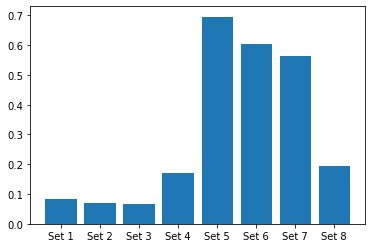

In [24]:
plt.bar(height  = kappa_per_set, x = [f'Set {i}' for i in range(1, 9)])

In [39]:
torch.cuda.empty_cache() # PyTorch thing


## GloVe + LSTM Trained As A Whole

In [22]:
t = Tokenizer()


s2_df = df[['domain1_score', 'cleaned']]
train, test = train_test_split(s2_df, test_size = 0.2, random_state = 42)

train['vecs'] = train['cleaned'].apply(lambda x : embed_glove(x, t))
test['vecs'] = test['cleaned'].apply(lambda x : embed_glove(x, t))

train_essayset = EssayDataset(train)
train_dataloader = DataLoader(dataset = train_essayset, batch_size = 128, shuffle = False, collate_fn = collate_fn)

test_essayset = EssayDataset(test)
test_dataloader = DataLoader(dataset = test_essayset, batch_size = 128, shuffle = False, collate_fn = collate_fn) 

In [26]:
embedding_matrix = create_embedding_matrix(t.word_index, glove, dim = 200)

INPUT_SIZE = embedding_matrix.shape[0]
text_embedding_dim = 200
HIDDEN_SIZE = 512
OUTPUT = 1
lr = 0.003

lstm_model = LSTMNetwork(INPUT_SIZE, text_embedding_dim, HIDDEN_SIZE, OUTPUT, embedding_matrix)
lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(),lr=lr)  

EPOCHS = 50



train_accs = []
train_losses = []
kappa_epoch = []

for epoch in range(EPOCHS):
    train_acc, train_loss = train_model(train_dataloader, lstm_model, criterion, optimizer)
    test_acc, test_loss, kappa = evaluate(test_dataloader, lstm_model, criterion)

    print(f'Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc} | Train Loss: {train_loss} | Test Acc: {test_acc} | Test Loss: {test_loss}')
    print(f'Kappa for epoch{epoch} : {kappa}')


    train_accs.append(train_acc)
    train_losses.append(train_loss)
    kappa_epoch.append(kappa)


100%|██████████| 21/21 [00:01<00:00, 15.35it/s]


Epoch 1/50 | Train Acc: 0.023532774390243903 | Train Loss: 90.29716394005752 | Test Acc: 0.010788690476190476 | Test Loss: 78.91846593221028
Kappa for epoch0 : 0.0048926029777619715


100%|██████████| 21/21 [00:01<00:00, 14.42it/s]


Epoch 2/50 | Train Acc: 0.01915015243902439 | Train Loss: 79.81167118723799 | Test Acc: 0.010788690476190476 | Test Loss: 75.1082992553711
Kappa for epoch1 : 0.05463169817407945


100%|██████████| 21/21 [00:01<00:00, 15.44it/s]


Epoch 3/50 | Train Acc: 0.018673780487804877 | Train Loss: 84.6255859049355 | Test Acc: 0.010788690476190476 | Test Loss: 79.11011178152901
Kappa for epoch2 : -0.0007122337923037529


100%|██████████| 21/21 [00:01<00:00, 15.34it/s]


Epoch 4/50 | Train Acc: 0.03315548780487805 | Train Loss: 72.59478196865174 | Test Acc: 0.00818452380952381 | Test Loss: 59.49711663382394
Kappa for epoch3 : 0.4638600160721203


100%|██████████| 21/21 [00:01<00:00, 14.96it/s]


Epoch 5/50 | Train Acc: 0.08346036585365854 | Train Loss: 58.77362688576303 | Test Acc: 0.16493055579208193 | Test Loss: 52.91095869881766
Kappa for epoch4 : 0.5801608074206315


100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 6/50 | Train Acc: 0.09876778458313244 | Train Loss: 54.89684388695694 | Test Acc: 0.18613591293493906 | Test Loss: 48.940511067708336
Kappa for epoch5 : 0.6007872392796442


100%|██████████| 21/21 [00:01<00:00, 15.31it/s]


Epoch 7/50 | Train Acc: 0.09622713414634146 | Train Loss: 51.604797177198456 | Test Acc: 0.07891038361759413 | Test Loss: 46.669367109026226
Kappa for epoch6 : 0.6098459870617073


100%|██████████| 21/21 [00:01<00:00, 15.07it/s]


Epoch 8/50 | Train Acc: 0.09695757116849829 | Train Loss: 50.22381784857773 | Test Acc: 0.215360449893134 | Test Loss: 41.17045093718029
Kappa for epoch7 : 0.6749891961849879


100%|██████████| 21/21 [00:01<00:00, 15.26it/s]


Epoch 9/50 | Train Acc: 0.1325266768292683 | Train Loss: 45.79536361229129 | Test Acc: 0.11598875692912511 | Test Loss: 37.565645672026136
Kappa for epoch8 : 0.6756798114977278


100%|██████████| 21/21 [00:01<00:00, 15.23it/s]


Epoch 10/50 | Train Acc: 0.08927210365853659 | Train Loss: 43.96250750378864 | Test Acc: 0.14823082018466222 | Test Loss: 39.524346669514976
Kappa for epoch9 : 0.6560949461377357


100%|██████████| 21/21 [00:01<00:00, 15.28it/s]


Epoch 11/50 | Train Acc: 0.1130907012195122 | Train Loss: 40.95074246569378 | Test Acc: 0.09052579388732002 | Test Loss: 38.31437020074753
Kappa for epoch10 : 0.6313373826860009


100%|██████████| 21/21 [00:01<00:00, 14.94it/s]


Epoch 12/50 | Train Acc: 0.10966082317073171 | Train Loss: 42.51739320522401 | Test Acc: 0.137235449893134 | Test Loss: 29.02293450491769
Kappa for epoch11 : 0.7390521511882426


100%|██████████| 21/21 [00:01<00:00, 15.10it/s]


Epoch 13/50 | Train Acc: 0.1127731199489861 | Train Loss: 36.260840834640874 | Test Acc: 0.15653935216722034 | Test Loss: 35.23887952168783
Kappa for epoch12 : 0.664633324884279


100%|██████████| 21/21 [00:01<00:00, 14.81it/s]


Epoch 14/50 | Train Acc: 0.11401168702215683 | Train Loss: 37.0030838454642 | Test Acc: 0.13144841293493906 | Test Loss: 30.124399366832915
Kappa for epoch13 : 0.7254297190034082


100%|██████████| 21/21 [00:01<00:00, 15.00it/s]


Epoch 15/50 | Train Acc: 0.1319232723880105 | Train Loss: 36.88678501873481 | Test Acc: 0.128017526474737 | Test Loss: 21.07227425348191
Kappa for epoch14 : 0.8159460047511837


100%|██████████| 21/21 [00:01<00:00, 15.28it/s]


Epoch 16/50 | Train Acc: 0.13017657526382587 | Train Loss: 34.67841500770755 | Test Acc: 0.16637731485423587 | Test Loss: 22.913622129531134
Kappa for epoch15 : 0.7975854609462238


100%|██████████| 21/21 [00:01<00:00, 15.30it/s]


Epoch 17/50 | Train Acc: 0.14983485775386415 | Train Loss: 32.43913687729254 | Test Acc: 0.17509920646746954 | Test Loss: 22.734637669154576
Kappa for epoch16 : 0.8018706010679818


100%|██████████| 21/21 [00:01<00:00, 14.66it/s]


Epoch 18/50 | Train Acc: 0.1475165142882161 | Train Loss: 31.347543088401235 | Test Acc: 0.18985615103017717 | Test Loss: 21.63542284284319
Kappa for epoch17 : 0.8045353598932895


100%|██████████| 21/21 [00:01<00:00, 14.99it/s]


Epoch 19/50 | Train Acc: 0.1480564024390244 | Train Loss: 30.995917238840242 | Test Acc: 0.16807209026245845 | Test Loss: 21.129028729030065
Kappa for epoch18 : 0.8136609252129217


100%|██████████| 21/21 [00:01<00:00, 14.69it/s]


Epoch 20/50 | Train Acc: 0.16952489843455756 | Train Loss: 29.949041657331513 | Test Acc: 0.21457506645293462 | Test Loss: 20.629889351981028
Kappa for epoch19 : 0.8283354658313413


100%|██████████| 21/21 [00:01<00:00, 14.84it/s]


Epoch 21/50 | Train Acc: 0.18156122970508365 | Train Loss: 28.100265188914975 | Test Acc: 0.21192956361032667 | Test Loss: 23.598393440246582
Kappa for epoch20 : 0.7914993473979105


100%|██████████| 21/21 [00:01<00:00, 15.26it/s]


Epoch 22/50 | Train Acc: 0.17371697160528926 | Train Loss: 30.80547201342699 | Test Acc: 0.207547949893134 | Test Loss: 20.180008343287877
Kappa for epoch21 : 0.8220034520444512


100%|██████████| 21/21 [00:01<00:00, 13.60it/s]


Epoch 23/50 | Train Acc: 0.17555894311971781 | Train Loss: 29.882207475057463 | Test Acc: 0.2049437832264673 | Test Loss: 19.79730460757301
Kappa for epoch22 : 0.831367992609871


100%|██████████| 21/21 [00:01<00:00, 15.29it/s]


Epoch 24/50 | Train Acc: 0.19105691062967953 | Train Loss: 25.682145828154027 | Test Acc: 0.18444113788150607 | Test Loss: 19.697435696919758
Kappa for epoch23 : 0.830559970745684


100%|██████████| 21/21 [00:01<00:00, 14.87it/s]


Epoch 25/50 | Train Acc: 0.20452235775386415 | Train Loss: 24.83000110998386 | Test Acc: 0.19762731485423587 | Test Loss: 21.61842659541539
Kappa for epoch24 : 0.8188455441654906


100%|██████████| 21/21 [00:01<00:00, 15.32it/s]


Epoch 26/50 | Train Acc: 0.19709095531483975 | Train Loss: 25.837814424096084 | Test Acc: 0.17253637597674415 | Test Loss: 21.242790857950848
Kappa for epoch25 : 0.8255236016850712


100%|██████████| 21/21 [00:01<00:00, 15.29it/s]


Epoch 27/50 | Train Acc: 0.18762703258089902 | Train Loss: 25.915435593302657 | Test Acc: 0.19990079388732002 | Test Loss: 18.77058319818406
Kappa for epoch26 : 0.838771775199319


100%|██████████| 21/21 [00:01<00:00, 15.29it/s]


Epoch 28/50 | Train Acc: 0.20903201219512196 | Train Loss: 24.382312216409822 | Test Acc: 0.2502066805249169 | Test Loss: 18.038143475850422
Kappa for epoch27 : 0.8498938926112706


100%|██████████| 21/21 [00:01<00:00, 14.10it/s]


Epoch 29/50 | Train Acc: 0.20750762195121952 | Train Loss: 23.945223994371368 | Test Acc: 0.2163938493246124 | Test Loss: 24.52096680232457
Kappa for epoch28 : 0.7944515975253564


100%|██████████| 21/21 [00:01<00:00, 15.29it/s]


Epoch 30/50 | Train Acc: 0.18619791672724048 | Train Loss: 30.384653568267822 | Test Acc: 0.20229828073864892 | Test Loss: 18.802802222115652
Kappa for epoch29 : 0.8359502380291547


100%|██████████| 21/21 [00:01<00:00, 15.25it/s]


Epoch 31/50 | Train Acc: 0.21265243902439024 | Train Loss: 23.38718906263026 | Test Acc: 0.23995535714285715 | Test Loss: 18.30907658168248
Kappa for epoch30 : 0.8467346169289014


100%|██████████| 21/21 [00:01<00:00, 15.20it/s]


Epoch 32/50 | Train Acc: 0.20356961385142514 | Train Loss: 21.80121042670273 | Test Acc: 0.21457506645293462 | Test Loss: 18.14052291143508
Kappa for epoch31 : 0.8447376065282477


100%|██████████| 21/21 [00:01<00:00, 15.00it/s]


Epoch 33/50 | Train Acc: 0.20852388214410805 | Train Loss: 21.689277875714186 | Test Acc: 0.23751653447037652 | Test Loss: 17.53870173863002
Kappa for epoch32 : 0.8509064071394542


100%|██████████| 21/21 [00:01<00:00, 15.02it/s]


Epoch 34/50 | Train Acc: 0.20839684983579124 | Train Loss: 21.599392757183168 | Test Acc: 0.22966269864922478 | Test Loss: 17.748344466799782
Kappa for epoch33 : 0.8489862772730903


100%|██████████| 21/21 [00:01<00:00, 14.92it/s]


Epoch 35/50 | Train Acc: 0.2126206810154566 | Train Loss: 22.299510374301818 | Test Acc: 0.24475033084551492 | Test Loss: 18.79519458044143
Kappa for epoch34 : 0.8442803114867659


100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 36/50 | Train Acc: 0.2129700203857771 | Train Loss: 22.75500275449055 | Test Acc: 0.2438822757630121 | Test Loss: 17.93953273409889
Kappa for epoch35 : 0.8488517856184752


100%|██████████| 21/21 [00:01<00:00, 14.90it/s]


Epoch 37/50 | Train Acc: 0.21277947160528926 | Train Loss: 21.51124295374242 | Test Acc: 0.24925595238095238 | Test Loss: 18.390613192603702
Kappa for epoch36 : 0.840881772651262


100%|██████████| 21/21 [00:01<00:00, 15.23it/s]


Epoch 38/50 | Train Acc: 0.22348196141240073 | Train Loss: 20.741714617101156 | Test Acc: 0.20622519864922478 | Test Loss: 18.779038656325568
Kappa for epoch37 : 0.8388163015061098


100%|██████████| 21/21 [00:01<00:00, 14.58it/s]


Epoch 39/50 | Train Acc: 0.22611788623943563 | Train Loss: 21.371899221001602 | Test Acc: 0.24925595238095238 | Test Loss: 23.92483938307989
Kappa for epoch38 : 0.8188896437873203


100%|██████████| 21/21 [00:01<00:00, 15.16it/s]


Epoch 40/50 | Train Acc: 0.19213668702215683 | Train Loss: 27.3464540388526 | Test Acc: 0.25632440476190477 | Test Loss: 17.54995500473749
Kappa for epoch39 : 0.8519032439199206


100%|██████████| 21/21 [00:01<00:00, 15.14it/s]


Epoch 41/50 | Train Acc: 0.21576473589350537 | Train Loss: 21.82124548423581 | Test Acc: 0.2235449737026578 | Test Loss: 18.57109260559082
Kappa for epoch40 : 0.8413182340959724


100%|██████████| 21/21 [00:01<00:00, 14.93it/s]


Epoch 42/50 | Train Acc: 0.2302146852016449 | Train Loss: 19.312432765960693 | Test Acc: 0.24549437846456254 | Test Loss: 17.647586322966077
Kappa for epoch41 : 0.8532471264608165


100%|██████████| 21/21 [00:01<00:00, 15.14it/s]


Epoch 43/50 | Train Acc: 0.2225927339821327 | Train Loss: 18.550548797700465 | Test Acc: 0.22094080703599112 | Test Loss: 19.230467342195055
Kappa for epoch42 : 0.837398061091501


100%|██████████| 21/21 [00:01<00:00, 15.16it/s]


Epoch 44/50 | Train Acc: 0.22345020331260634 | Train Loss: 19.118180280778468 | Test Acc: 0.25318287100110737 | Test Loss: 18.33412184034075
Kappa for epoch43 : 0.8429777838194612


100%|██████████| 21/21 [00:01<00:00, 15.34it/s]


Epoch 45/50 | Train Acc: 0.23443851638131025 | Train Loss: 17.312007369064702 | Test Acc: 0.2568617725656146 | Test Loss: 17.74393349602109
Kappa for epoch44 : 0.8489424538794947


100%|██████████| 21/21 [00:01<00:00, 14.96it/s]


Epoch 46/50 | Train Acc: 0.23167555897337636 | Train Loss: 17.47939784933881 | Test Acc: 0.2779017857142857 | Test Loss: 17.459313074747723
Kappa for epoch45 : 0.852420330911121


100%|██████████| 21/21 [00:01<00:00, 15.21it/s]


Epoch 47/50 | Train Acc: 0.22970655487804878 | Train Loss: 17.952310416756607 | Test Acc: 0.25963128322646734 | Test Loss: 20.054570561363583
Kappa for epoch46 : 0.8300381104979634


100%|██████████| 21/21 [00:01<00:00, 15.30it/s]


Epoch 48/50 | Train Acc: 0.23307291672724048 | Train Loss: 17.735087086514728 | Test Acc: 0.2737681879883721 | Test Loss: 20.50606832050142
Kappa for epoch47 : 0.8354247635721841


100%|██████████| 21/21 [00:01<00:00, 14.80it/s]


Epoch 49/50 | Train Acc: 0.24768165653435195 | Train Loss: 16.599724577694403 | Test Acc: 0.26111937846456257 | Test Loss: 25.108724457877024
Kappa for epoch48 : 0.7971081486850011


100%|██████████| 21/21 [00:01<00:00, 15.19it/s]

Epoch 50/50 | Train Acc: 0.23393038623943563 | Train Loss: 17.813195257652097 | Test Acc: 0.2568617725656146 | Test Loss: 18.804328963870095
Kappa for epoch49 : 0.8409712577633632


In [46]:
ave_kappa = np.mean(kappa_epoch)
ave_kappa

0.7399263623221793

## Machine Learning Models

In [40]:
#support vector regression
clf_svm = svm.SVC(kernel = 'linear')
#random forest
clf_rfc = RandomForestClassifier(n_estimators = 100)
#logistic regression
clf_log = LogisticRegression(solver='lbfgs', max_iter=200)
#Gaussian Naive Bayes
clf_nb = GaussianNB()
#XGBoost
clf_XG = XGBClassifier()

svm_kappa_set = []
rfc_kappa_set = []
log_kappa_set = []
nb_kappa_set = []
XG_kappa_set = []

vectorizer = TfidfVectorizer(analyzer = clean_data)

for idx ,df_set in enumerate(sets):
    print(f'Set {idx+1}')
    train, test = train_test_split(df_set, test_size = 0.2, random_state = 42)
    
    train.reset_index(drop = True, inplace=True)
    test.reset_index(drop = True, inplace=True)
    
    train_feat_df = train[['essay_length', 'word_count', 'sentence_count', 'unique_words', 'lexical_richness', 'punctuation_count', 'spelling_errors', 'noun_%', 'pronoun_%', 'verb_%', 'adj_%', 'dt_%']]
    test_feat_df = test[['essay_length', 'word_count', 'sentence_count', 'unique_words', 'lexical_richness', 'punctuation_count', 'spelling_errors', 'noun_%', 'pronoun_%', 'verb_%', 'adj_%', 'dt_%']]
    
    x_data_train = train['essay']
    y_data_train = train['domain1_score']

    x_data_test = test['essay']
    y_data_test = test['domain1_score']

    #vectorize training and test data
    
    x_data_trainv = pd.concat([pd.DataFrame(vectorizer.fit_transform(x_data_train).toarray()), train_feat_df], axis = 1)
    x_data_testv = pd.concat([pd.DataFrame(vectorizer.transform(x_data_test).toarray()), test_feat_df], axis = 1)
    
    clf_svm.fit(sc.fit_transform(x_data_trainv), y_data_train)
    clf_rfc.fit(sc.fit_transform(x_data_trainv), y_data_train)
    clf_log.fit(sc.fit_transform(x_data_trainv), y_data_train)
    clf_nb.fit(sc.fit_transform(x_data_trainv), y_data_train)
    clf_XG.fit(sc.fit_transform(x_data_trainv), y_data_train)
    
    svm_preds = clf_svm.predict(sc.fit_transform(x_data_testv))
    rfc_preds = clf_rfc.predict(sc.fit_transform(x_data_testv))
    log_preds = clf_log.predict(sc.fit_transform(x_data_testv))
    nb_preds = clf_nb.predict(sc.fit_transform(x_data_testv))
    XG_preds = clf_XG.predict(sc.fit_transform(x_data_testv))
    
    
    svm_kappa = cohen_kappa_score(y_data_test.values, svm_preds ,weights='quadratic')
    rfc_kappa = cohen_kappa_score(y_data_test.values, rfc_preds ,weights='quadratic')
    log_kappa = cohen_kappa_score(y_data_test.values, log_preds ,weights='quadratic')
    nb_kappa = cohen_kappa_score(y_data_test.values, nb_preds ,weights='quadratic')
    XG_kappa = cohen_kappa_score(y_data_test.values, XG_preds ,weights='quadratic')
    
    
    
    print(f'SVM Score: {clf_svm.score(x_data_testv, y_data_test)}, RFC Score: {clf_rfc.score(x_data_testv, y_data_test)} LOG Score: {clf_log.score(x_data_testv, y_data_test)}, NB Score: {clf_nb.score(x_data_testv, y_data_test)}, XGB Score: {clf_XG.score(x_data_testv, y_data_test)} ')
    print(f'SVM Kappa: {svm_kappa}, RFC Kappa: {rfc_kappa} LOG Kappa: {log_kappa}, NB Kappa: {nb_kappa}, XGB Kappa: {XG_kappa}')
    
    svm_kappa_set.append(svm_kappa)
    rfc_kappa_set.append(rfc_kappa)
    log_kappa_set.append(log_kappa)
    nb_kappa_set.append(nb_kappa)
    XG_kappa_set.append(XG_kappa)
    


Set 1


C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.014005602240896359, RFC Score: 0.1792717086834734 LOG Score: 0.1792717086834734, NB Score: 0.37815126050420167, XGB Score: 0.1792717086834734 
SVM Kappa: 0.35729880874861153, RFC Kappa: 0.47995621836092484 LOG Kappa: 0.3244509568223496, NB Kappa: 0.21358634287736566, XGB Kappa: 0.8103232088656873
Set 2


C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.05, RFC Score: 0.43333333333333335 LOG Score: 0.43333333333333335, NB Score: 0.43333333333333335, XGB Score: 0.43333333333333335 
SVM Kappa: 0.5048415492957746, RFC Kappa: 0.5772708009605876 LOG Kappa: 0.4457300686772171, NB Kappa: 0.1733900014407146, XGB Kappa: 0.6335504885993485
Set 3


C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.26011560693641617, RFC Score: 0.26011560693641617 LOG Score: 0.26011560693641617, NB Score: 0.26011560693641617, XGB Score: 0.26011560693641617 
SVM Kappa: 0.5618621973929236, RFC Kappa: 0.6685193581886528 LOG Kappa: 0.5650502092669003, NB Kappa: -0.06968955300785762, XGB Kappa: 0.669731467314252
Set 4


C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:29:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.14124293785310735, RFC Score: 0.1553672316384181 LOG Score: 0.1384180790960452, NB Score: 0.327683615819209, XGB Score: 0.14124293785310735 
SVM Kappa: 0.657821708085186, RFC Kappa: 0.7262005838635015 LOG Kappa: 0.6456049972365032, NB Kappa: 0.089992082807964, XGB Kappa: 0.7711154971755257
Set 5


C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:29:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.12742382271468145, RFC Score: 0.12742382271468145 LOG Score: 0.12742382271468145, NB Score: 0.3601108033240997, XGB Score: 0.12742382271468145 
SVM Kappa: 0.6442186879656226, RFC Kappa: 0.7551435677142211 LOG Kappa: 0.6065292988010589, NB Kappa: 0.04590668097579731, XGB Kappa: 0.7671296078741301
Set 6


C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.19444444444444445, RFC Score: 0.19444444444444445 LOG Score: 0.19444444444444445, NB Score: 0.46111111111111114, XGB Score: 0.19444444444444445 
SVM Kappa: 0.6351351351351351, RFC Kappa: 0.7205093833780161 LOG Kappa: 0.51137339055794, NB Kappa: 0.05724999999999991, XGB Kappa: 0.7569896591344313
Set 7


C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:30:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.05732484076433121, RFC Score: 0.05732484076433121 LOG Score: 0.05732484076433121, NB Score: 0.05732484076433121, XGB Score: 0.054140127388535034 
SVM Kappa: 0.2697769822709397, RFC Kappa: 0.685988647218579 LOG Kappa: 0.3954939343832369, NB Kappa: 0.17504970681575005, XGB Kappa: 0.7289289044637728
Set 8


C:\Users\cvaal\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cvaal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SVM Score: 0.013793103448275862, RFC Score: 0.2413793103448276 LOG Score: 0.2413793103448276, NB Score: 0.2413793103448276, XGB Score: 0.2413793103448276 
SVM Kappa: 0.003964111496678635, RFC Kappa: 0.3113701221196664 LOG Kappa: 0.20877308898278069, NB Kappa: 0.05477013268434772, XGB Kappa: 0.5066454321125458


In [ ]:
kappa_epoch

In [41]:
print('SVM Average Kappa Score:', np.mean(np.asarray(svm_kappa_set)))
print('RFC Average Kappa Score:', np.mean(np.asarray(rfc_kappa_set)))
print('LOG Average Kappa Score:', np.mean(np.asarray(log_kappa_set)))
print('NB Average Kappa Score:', np.mean(np.asarray(nb_kappa_set)))
print('XGB Average Kappa Score:', np.mean(np.asarray(XG_kappa_set)))

SVM Average Kappa Score: 0.454364897548859
RFC Average Kappa Score: 0.6156198352255187
LOG Average Kappa Score: 0.4628757430909983
NB Average Kappa Score: 0.0925319243242602
XGB Average Kappa Score: 0.7055517831924617


<BarContainer object of 5 artists>

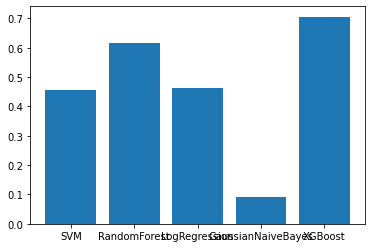

In [42]:
clfs = ['SVM', 'RandomForest', 'LogRegression', 'GaussianNaiveBayes', 'XGBoost']
scores = [np.mean(np.asarray(svm_kappa_set)), np.mean(np.asarray(rfc_kappa_set)), np.mean(np.asarray(log_kappa_set)), np.mean(np.asarray(nb_kappa_set)), np.mean(np.asarray(XG_kappa_set))]
plt.bar(clfs, height = scores)